### Best & Worst outcome group comparison - 28th Oct 2017

Add test, overlapping coefficient and kl divergence for
+ Best vs Worst
+ Best vs Normal
+ Worst vs Normal

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy import integrate
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
import scipy.stats
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(20171024)

In [5]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'ALBUMIN':[3.5, 5.5], 
              'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'GLUCOSE':[70.0, 100.0],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145],
              'FREECALCIUM': [1.1, 1.35],
              'WBC': [3.5, 10.5]
             }
labs = dict((i, 0) for i in lab_ranges.keys())

mimic = pd.read_csv("all_data_minmax.csv", index_col=0)
lab_columns = mimic.columns.values[1:]
data = mimic.copy()

In [6]:
data[['subject_id', 'sodium_min', 'sodium_max']].head()

subject_id  sodium_min  sodium_max
0           3       136.0       153.0
1           4       135.0       141.0
2           6       134.0       138.0
3           9       136.0       140.0
4          11       138.0       142.0

In [7]:
def ResumeNorm(val1, val2):
    norm_dist = scipy.stats.norm
    norm_val1 = norm_dist.ppf(0.025)
    norm_val2 = norm_dist.ppf(0.975)
    a = (val1 - val2) / (norm_val1 - norm_val2)
    b = val1 - a * norm_val1
    return scipy.stats.norm(b, a)

In [8]:
def OverlapParam(dist1, dist2, lab):
    """
        Overlapping coefficient: integration of min value of two distribution over R. 
        For chloride, glucose, sodium, use large interval with focus point interval instead. 
    """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    if lab in ['CHLORIDE', 'GLUCOSE', 'SODIUM']:
        return integrate.quad(func, 0, 1000)
    else:
        return integrate.quad(func, -np.inf, np.inf)

# Best outcome group vs Normal
## Minimal value plots

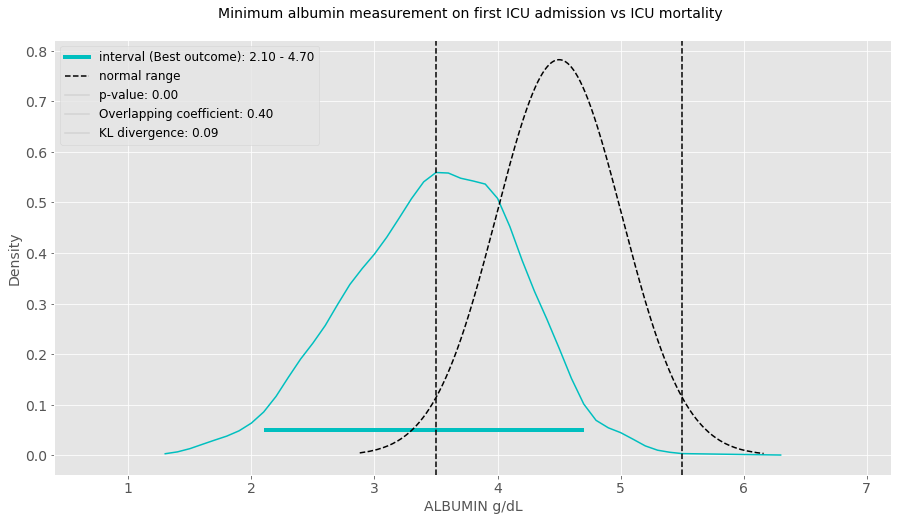

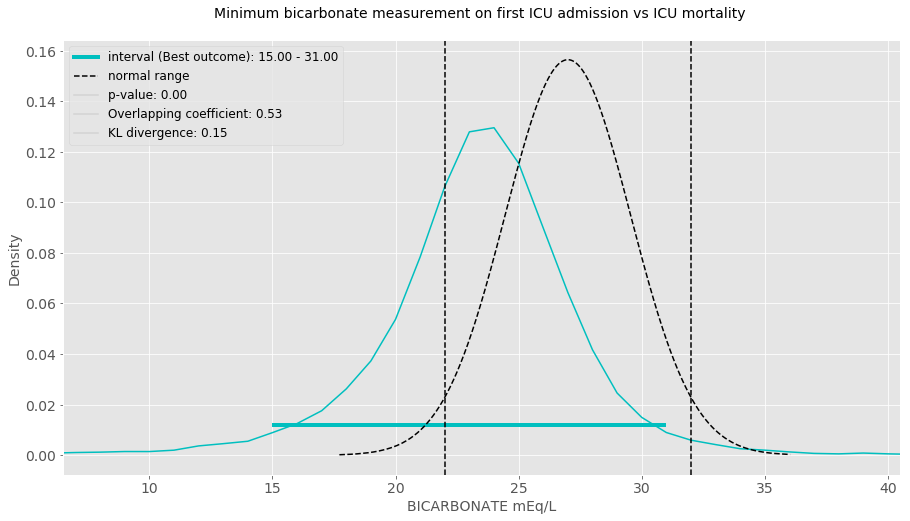

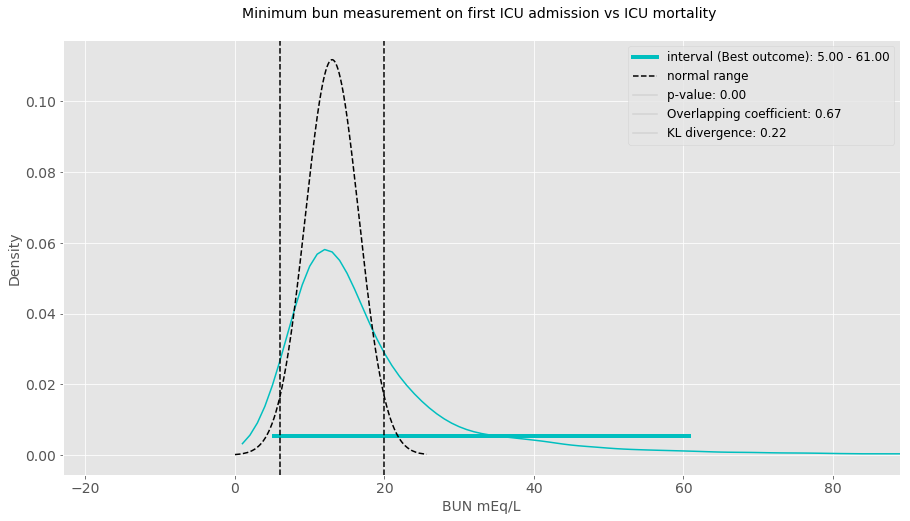

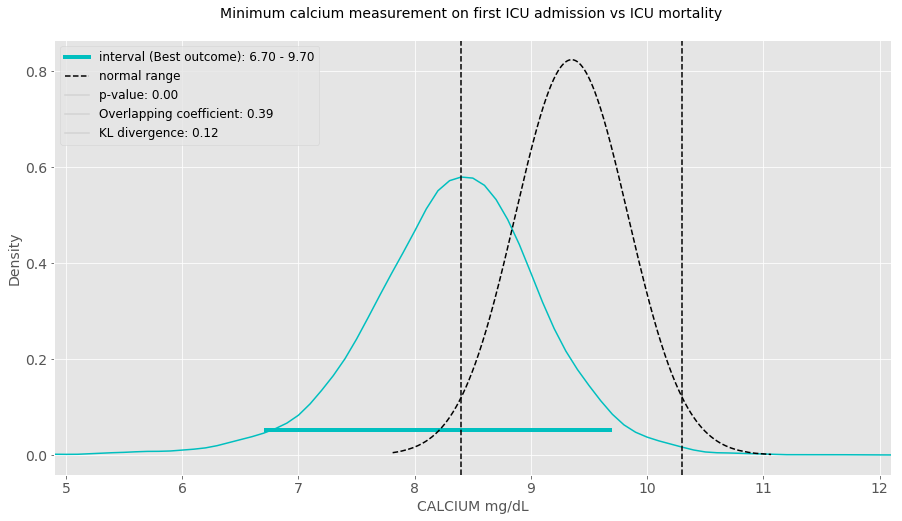

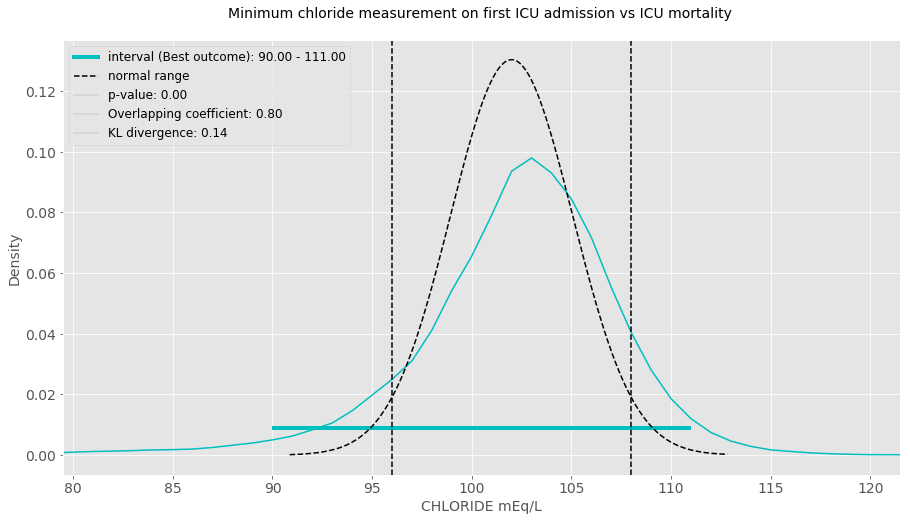

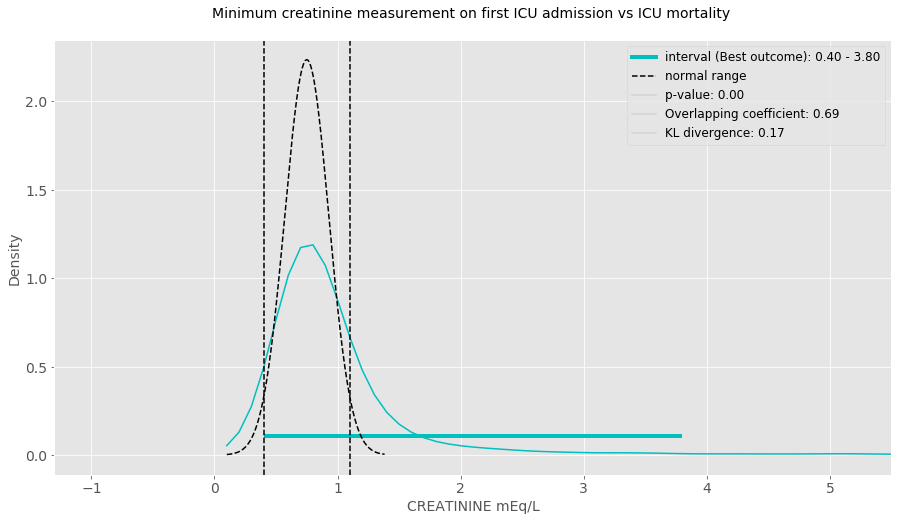

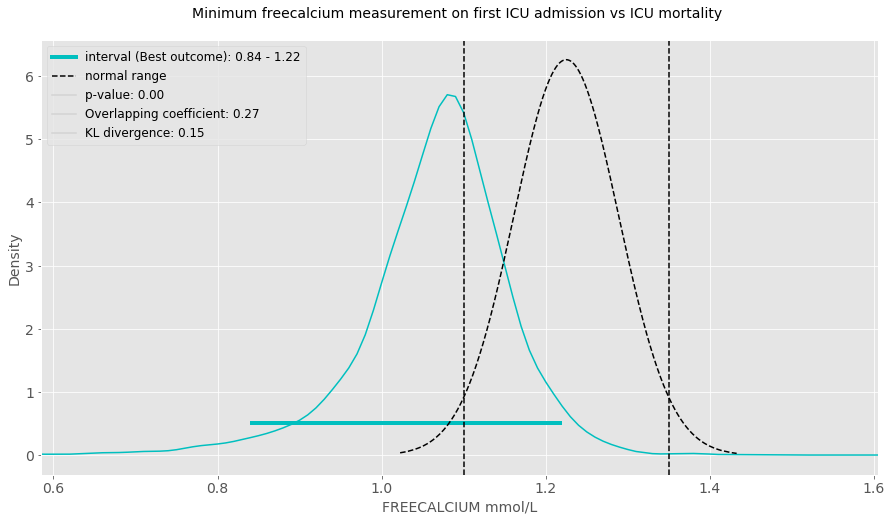

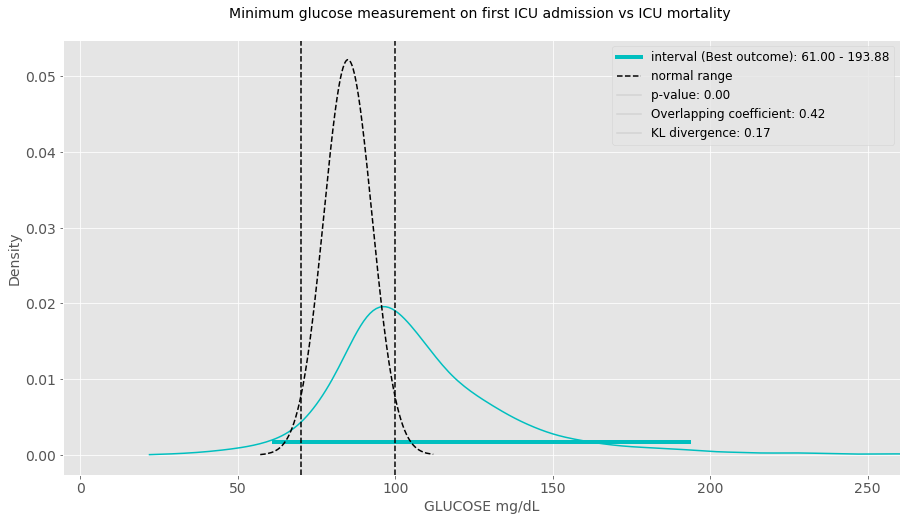

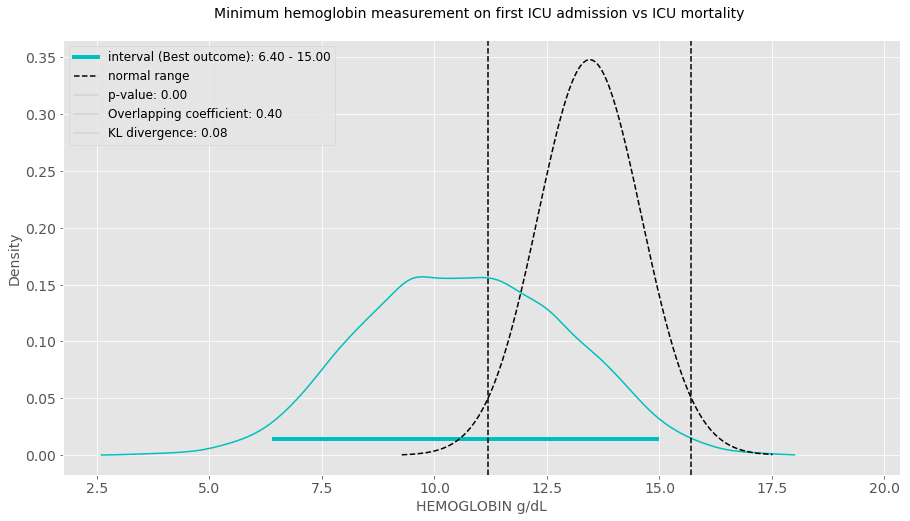

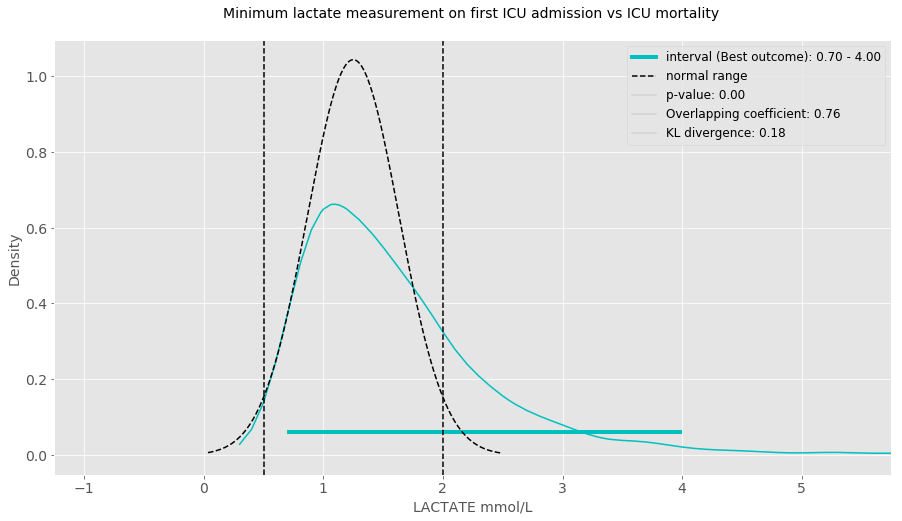

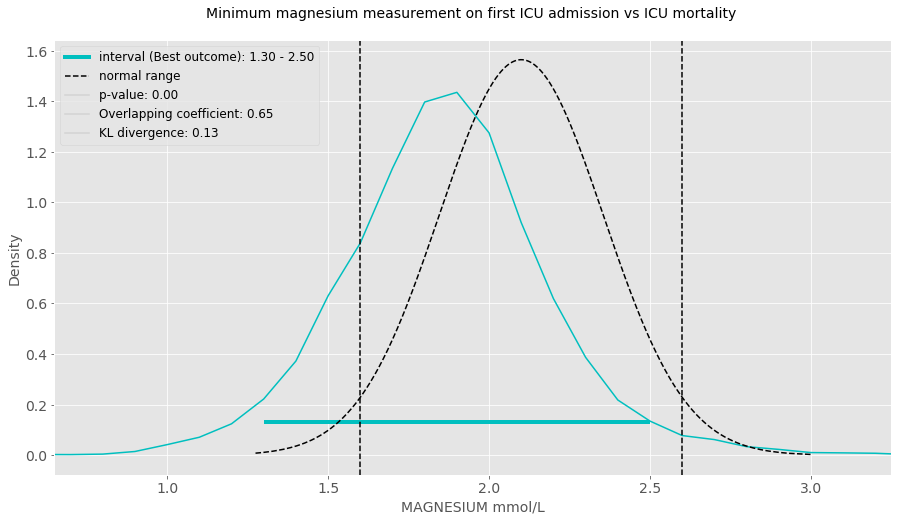

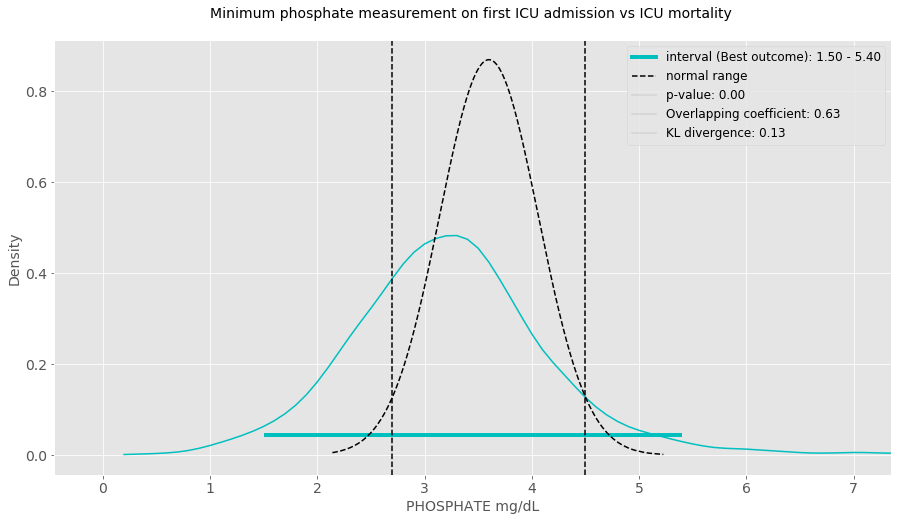

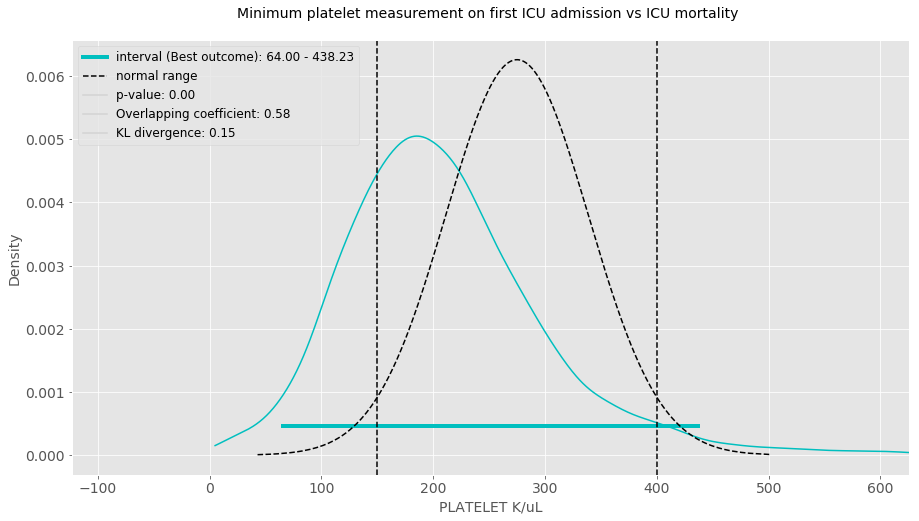

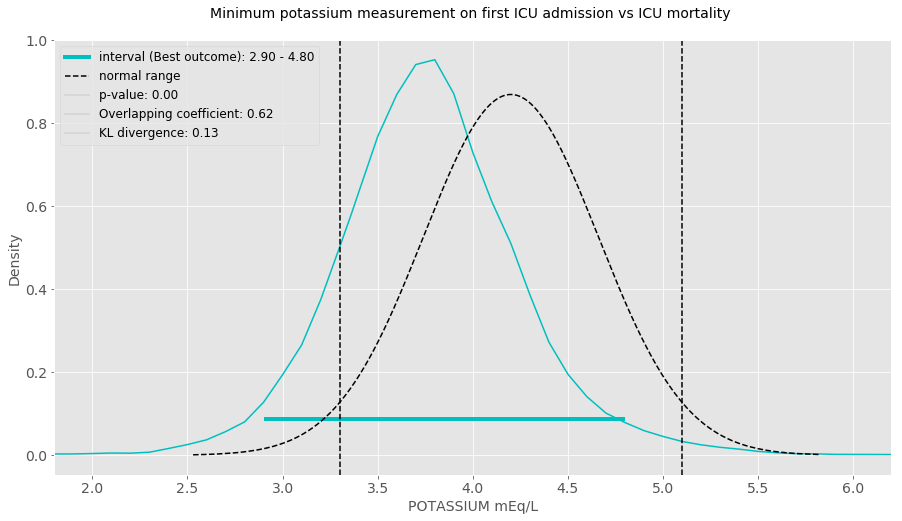

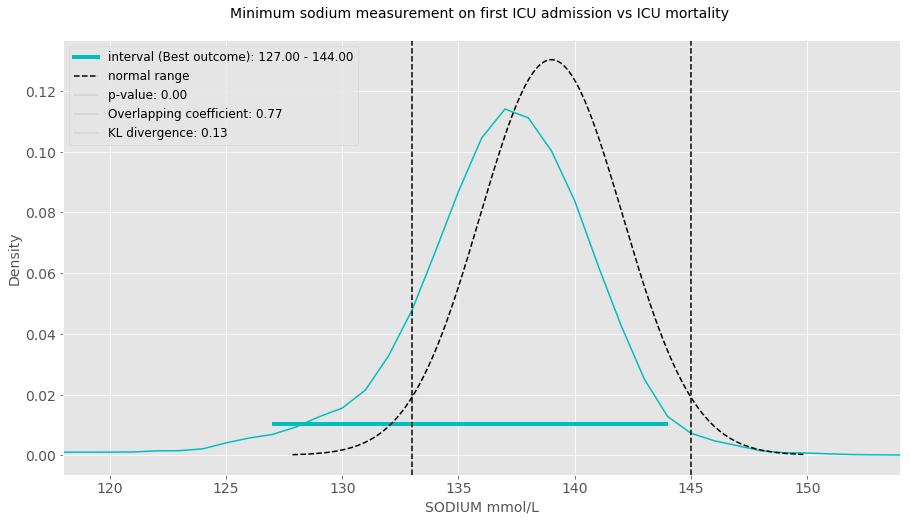

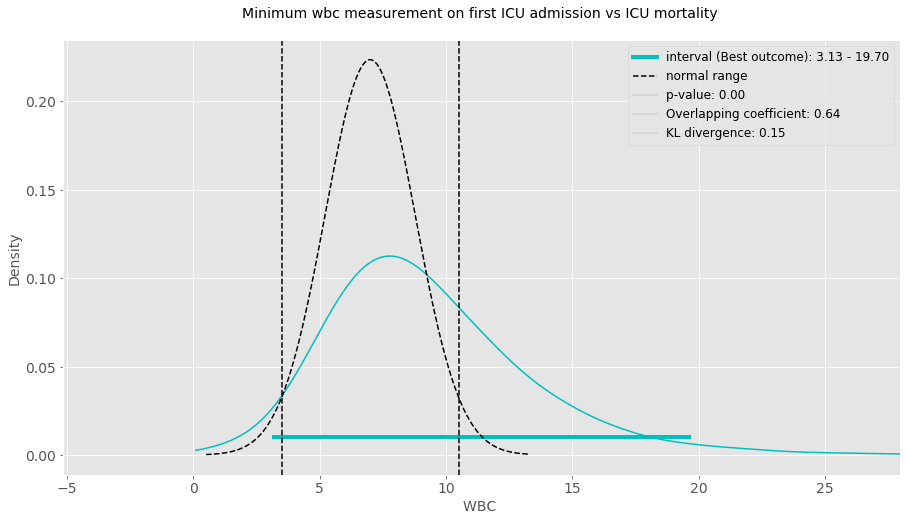

In [21]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_less = data[l.lower()+'_min'][cond_less].dropna().count()
    quater = n_less / 4 
    
    # get median, variance, mean
    med_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).median()
    var_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).var()
    skew_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).skew() 
    los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    # Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[l][0], lab_ranges[l][1])
    norm_sample = range_dist.rvs(size=quater, random_state=20171024)
    test_data = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater)
    
    # Change to non-parametric test to avoid making assumptions
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_min'].dropna())
    t_stat, p_val = mannwhitneyu(norm_sample, test_data)
    
    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    #data[l.lower()+'_min'].dropna().plot.kde(
    #    alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data_kde = gaussian_kde(test_data.as_matrix())
    plt.plot(test_data.sort_values(), data_kde.pdf(test_data.sort_values()), color='c')
    
    # Calculate KL divergence 
    kl = entropy(pk=data_kde.pdf(test_data), qk=norm_sample)    
    
    ovl = OverlapParam(data_kde, range_dist, l)
    # add 95% percentail 
    a1 = test_data.quantile(0.025)
    a2 = test_data.quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='c')
    
    # Plot label
    plt.plot([], label='interval (Best outcome): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='c', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='KL divergence: {}'.format(format(kl, '.2f')), color='lightgrey')
    plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Minimum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

## Maximum value plots

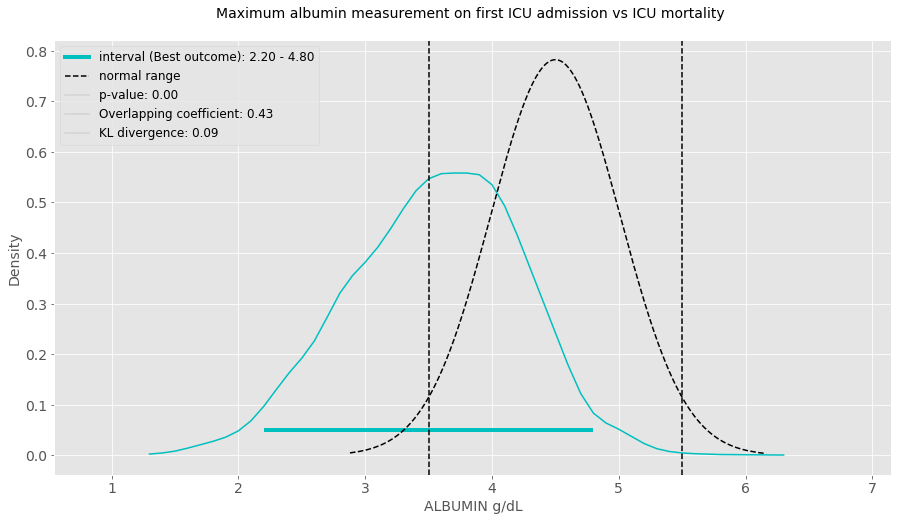

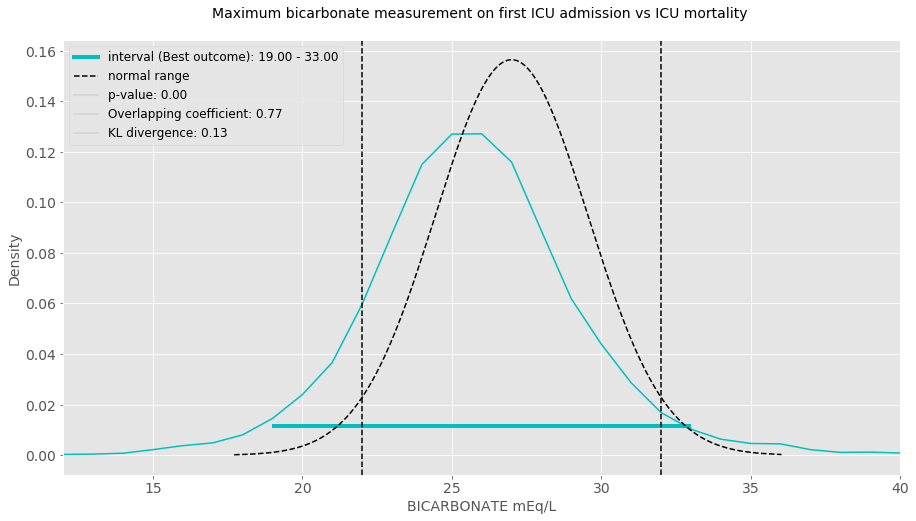

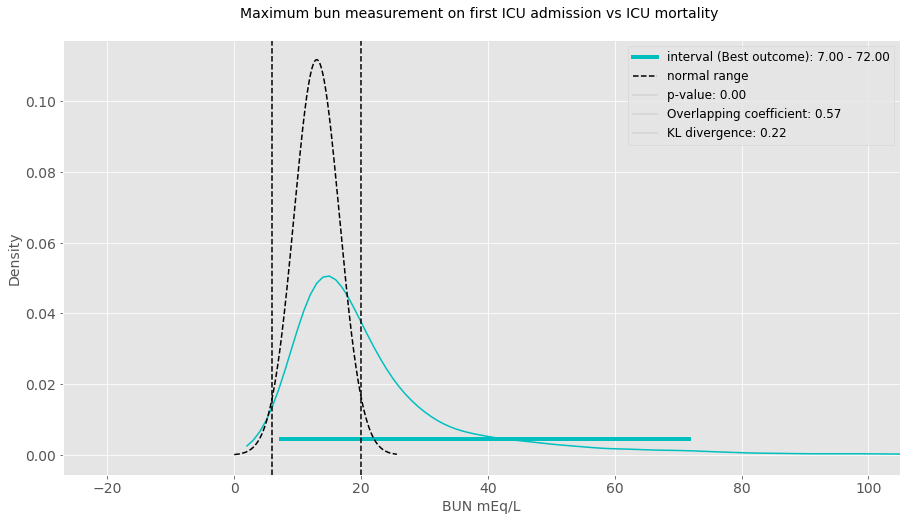

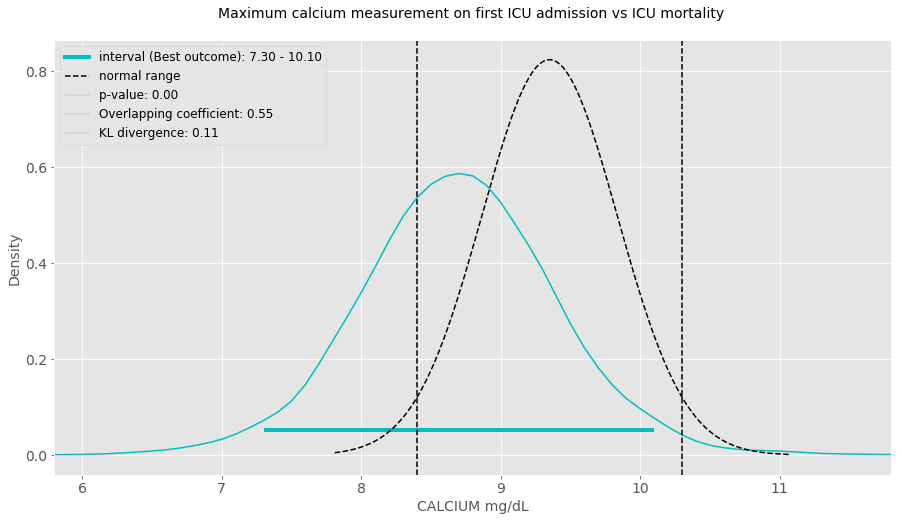

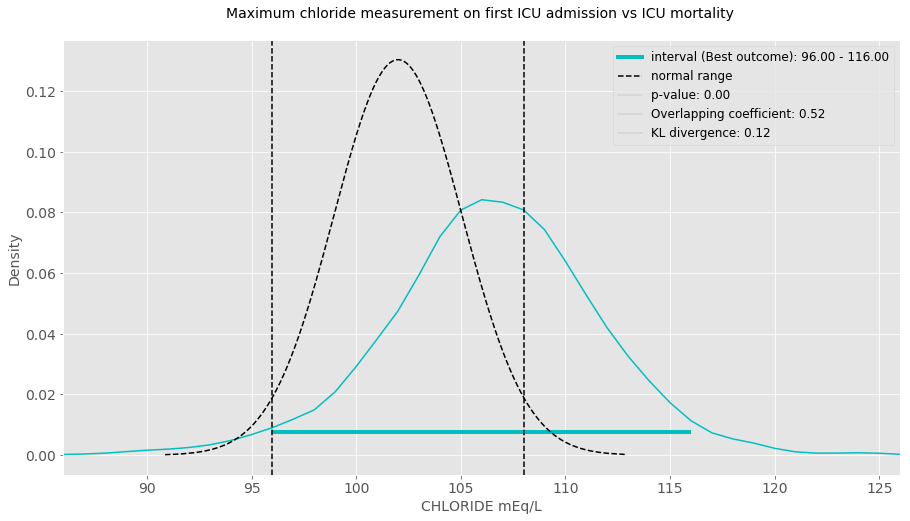

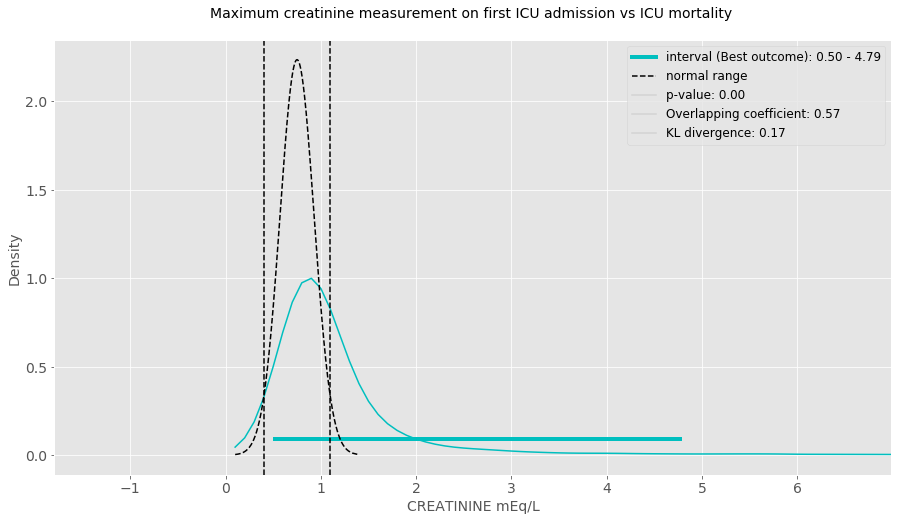

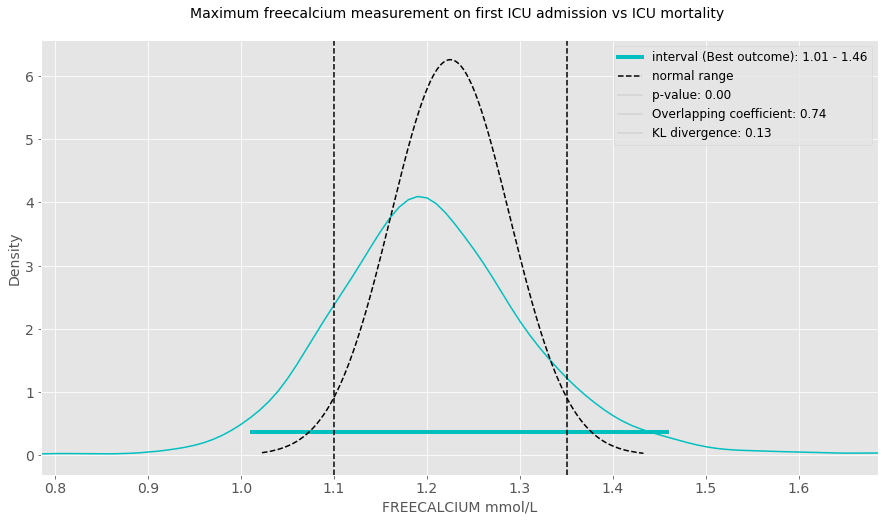

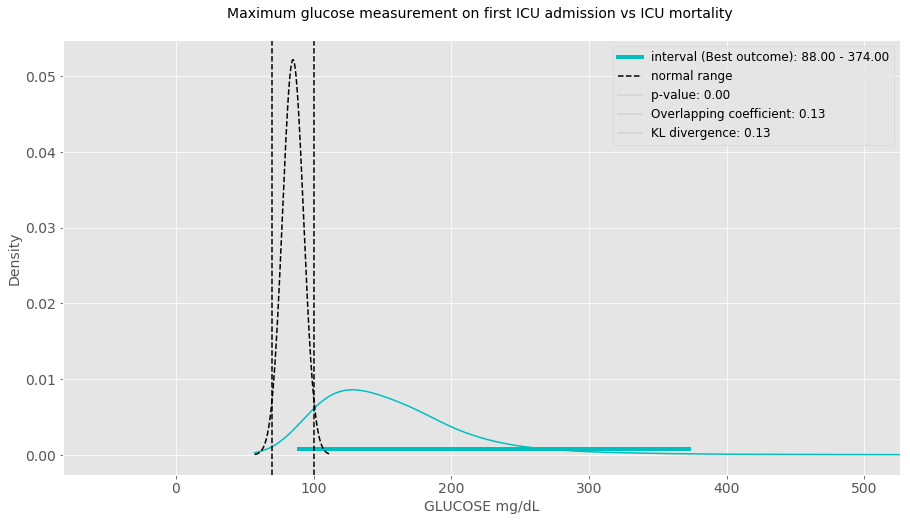

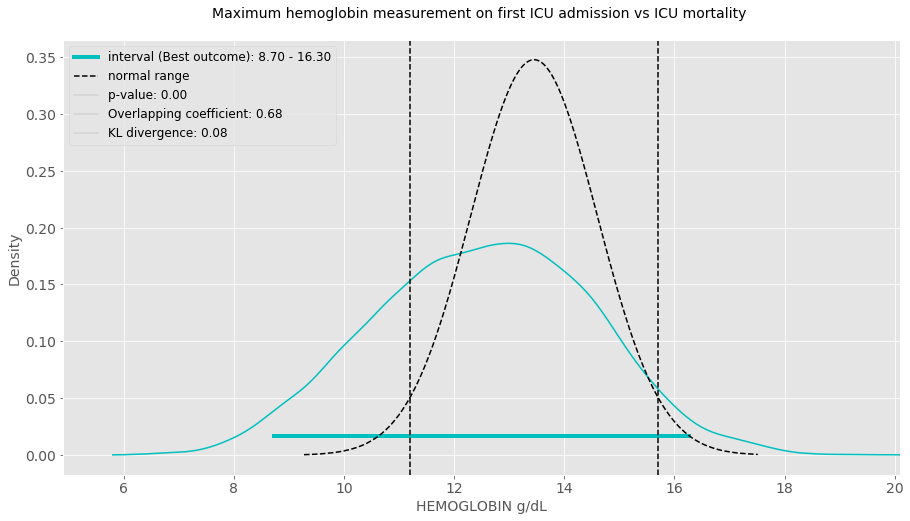

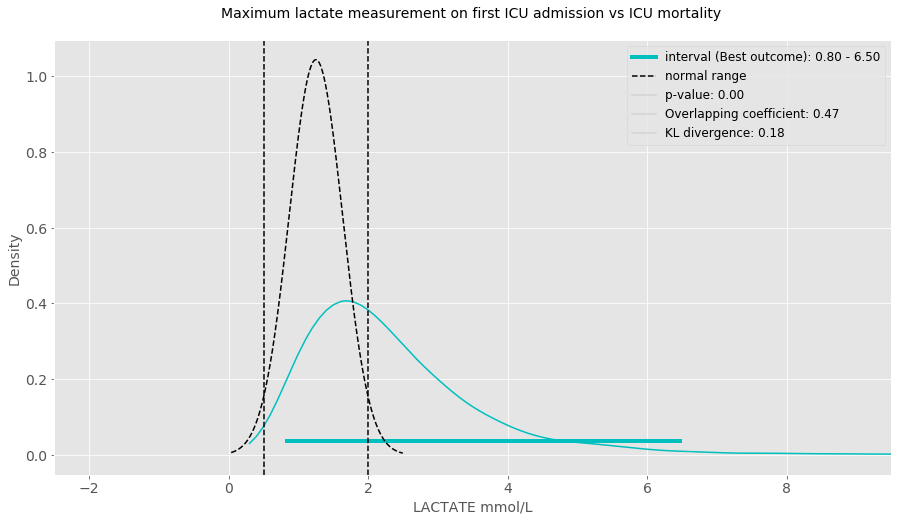

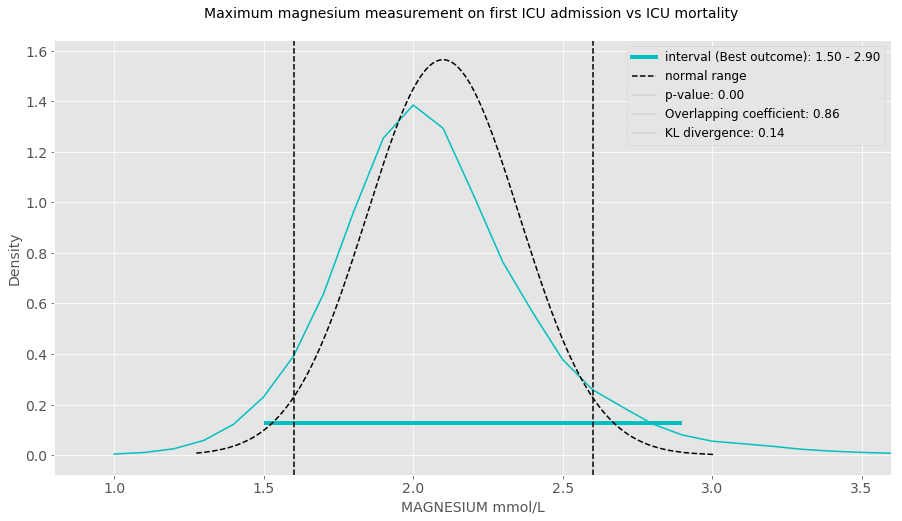

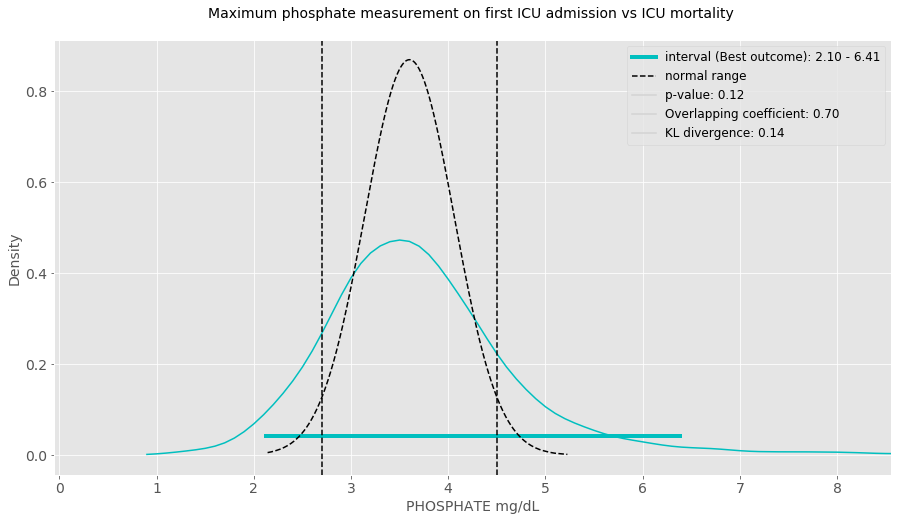

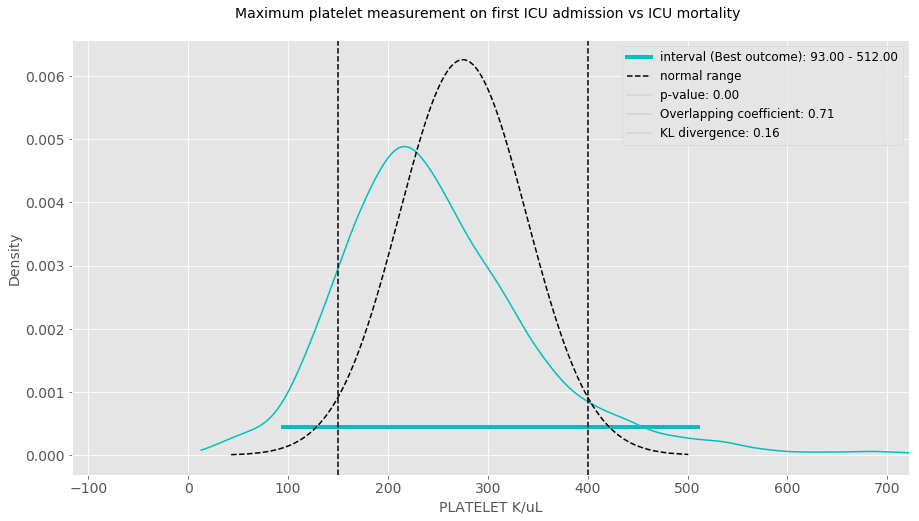

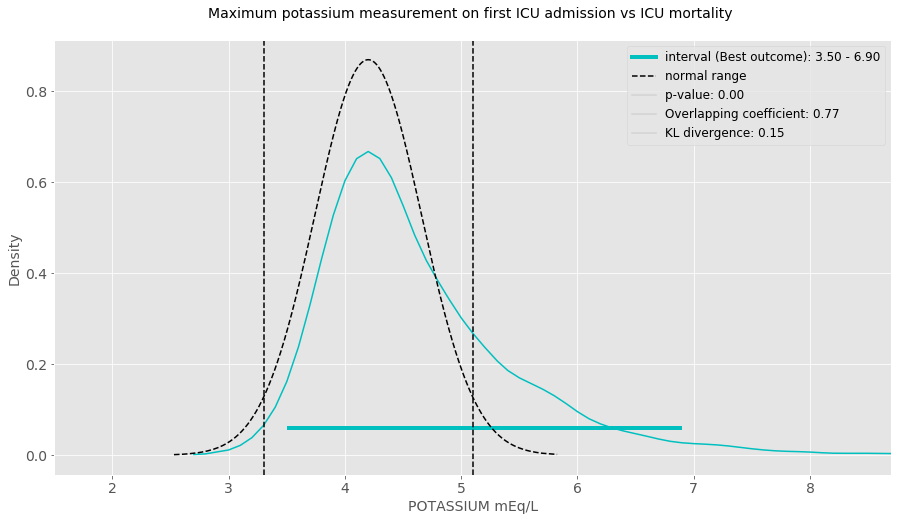

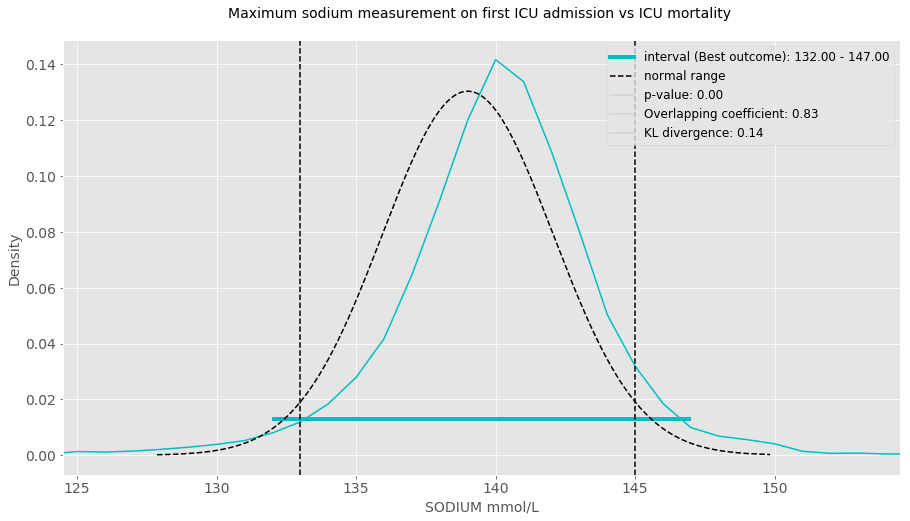

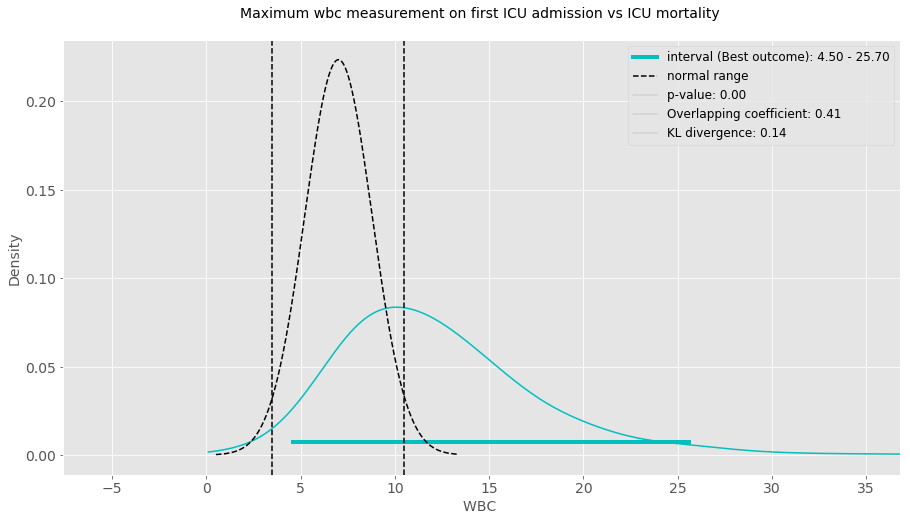

In [22]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_less = data[l.lower()+'_max'][cond_less].dropna().count()
    quater = n_less / 4 
    
    # get median, variance, mean
    med_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).median()
    var_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).var()
    skew_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).skew() 
    los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    # Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[l][0], lab_ranges[l][1])
    norm_sample = range_dist.rvs(size=quater, random_state=20171024)
    test_data = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater)
    
    # Change to non-parametric test to avoid making assumptions
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_min'].dropna())
    t_stat, p_val = mannwhitneyu(norm_sample, test_data)
    
    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    #data[l.lower()+'_min'].dropna().plot.kde(
    #    alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data_kde = gaussian_kde(test_data.as_matrix())
    plt.plot(test_data.sort_values(), data_kde.pdf(test_data.sort_values()), color='c')
    
    # Calculate KL divergence 
    kl = entropy(pk=data_kde.pdf(test_data), qk=norm_sample)    
    
    ovl = OverlapParam(data_kde, range_dist, l)
    # add 95% percentail 
    a1 = test_data.quantile(0.025)
    a2 = test_data.quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='c')
    
    # Plot label
    plt.plot([], label='interval (Best outcome): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='c', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='KL divergence: {}'.format(format(kl, '.2f')), color='lightgrey')
    plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Maximum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

# Worst outcome group vs Normal
## Minimal value plots

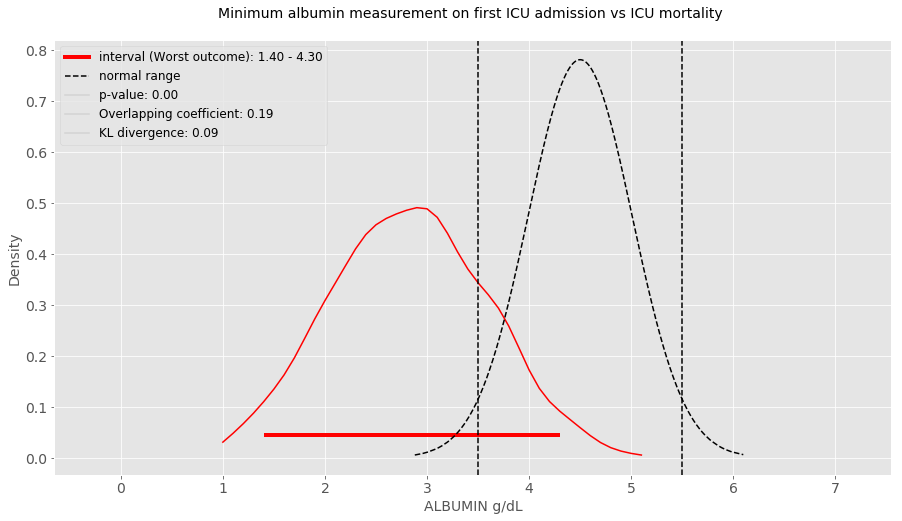

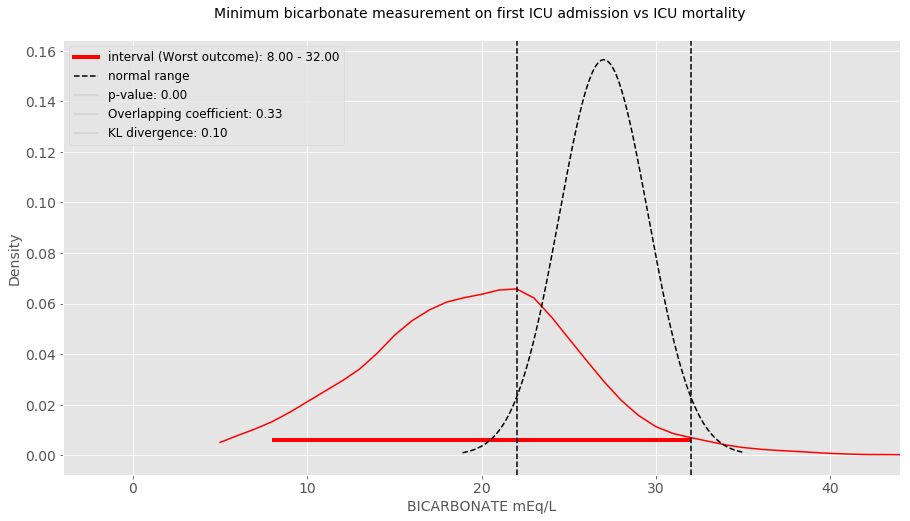

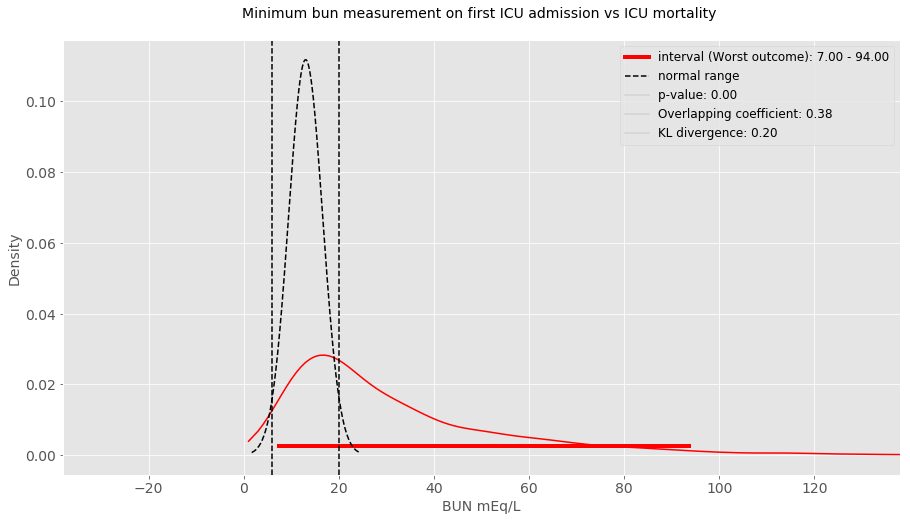

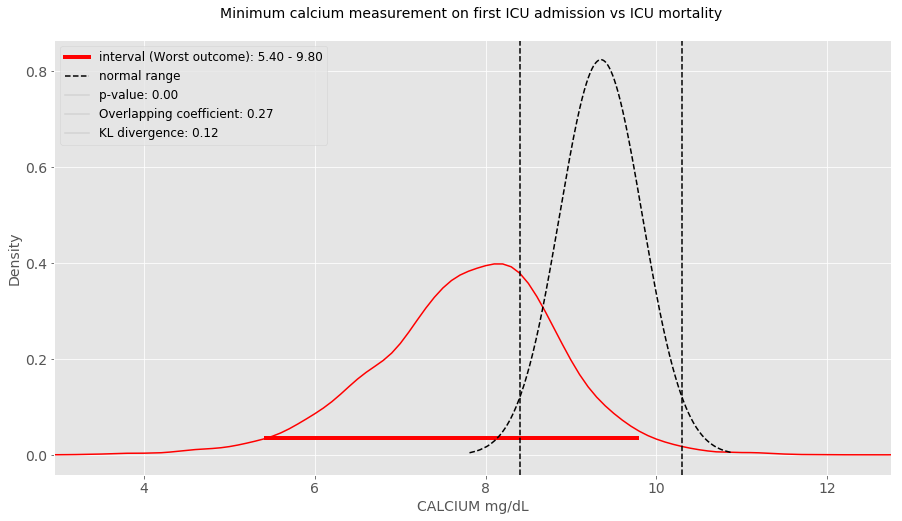

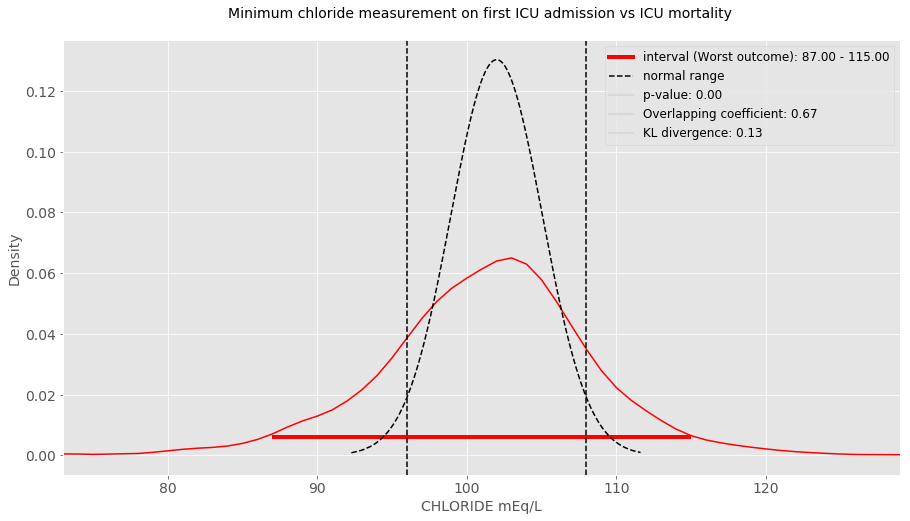

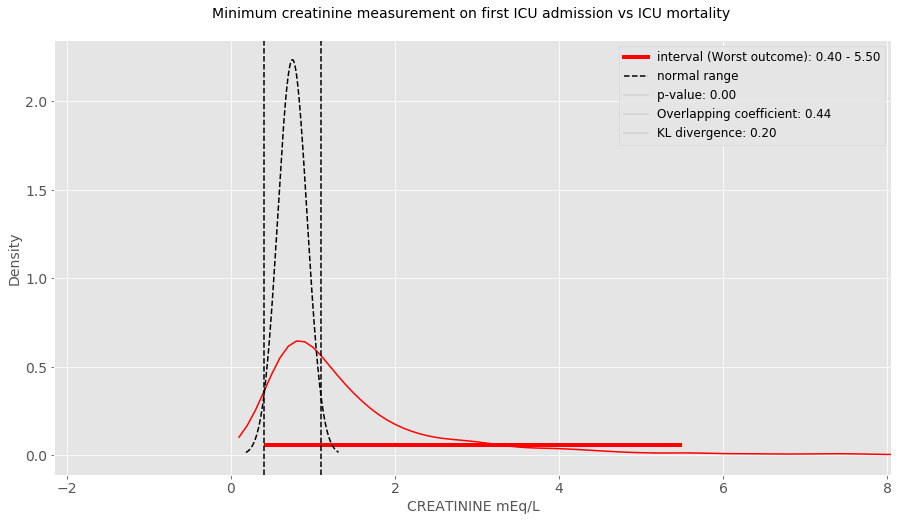

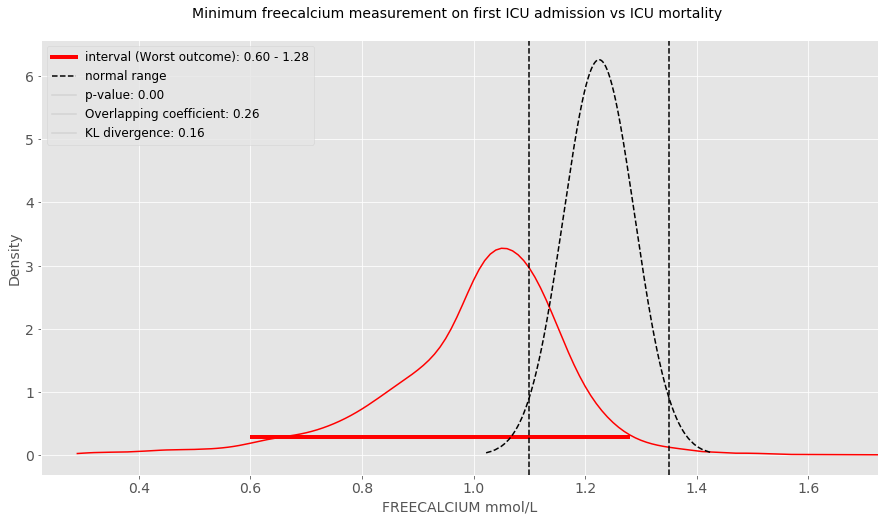

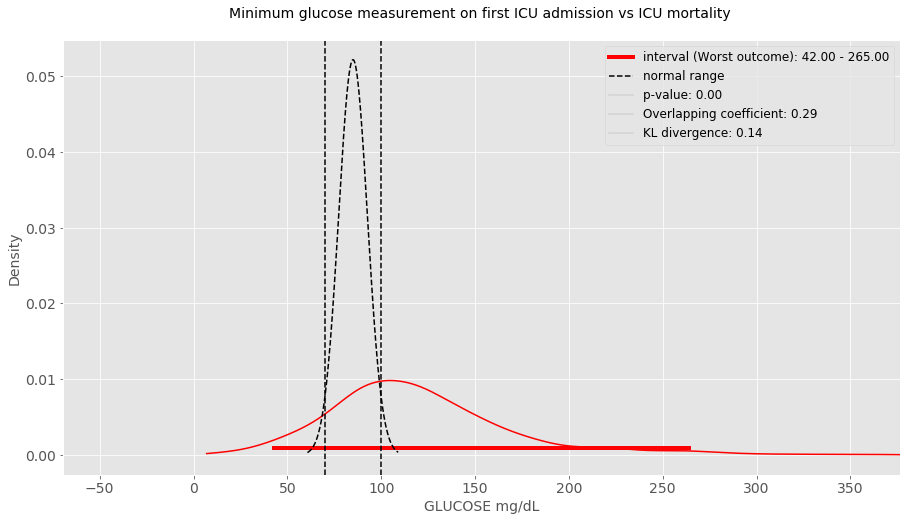

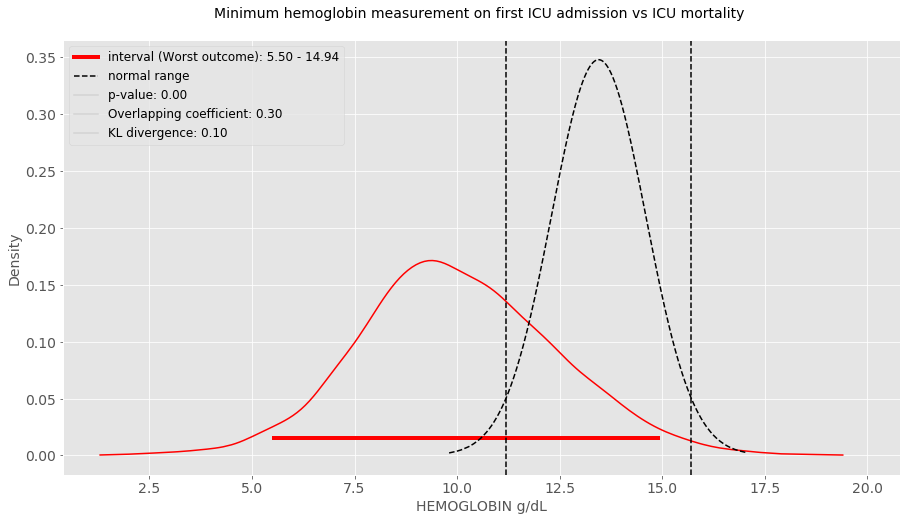

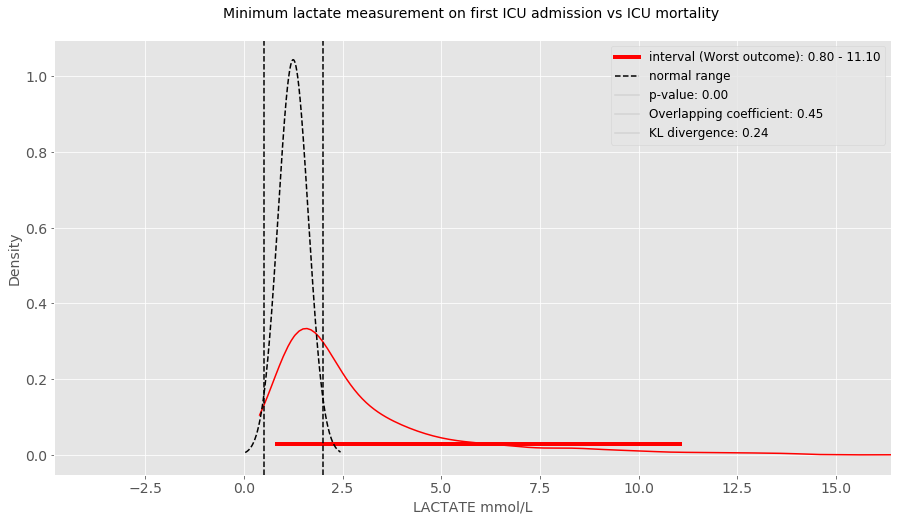

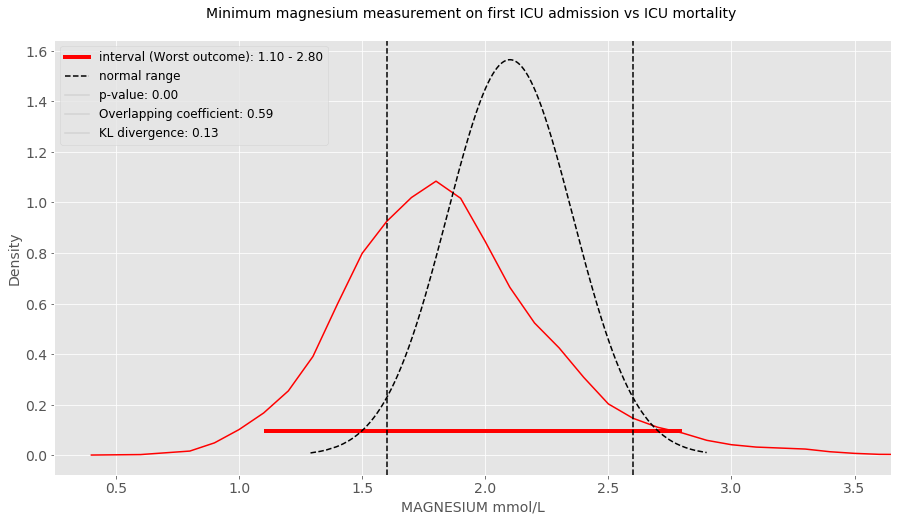

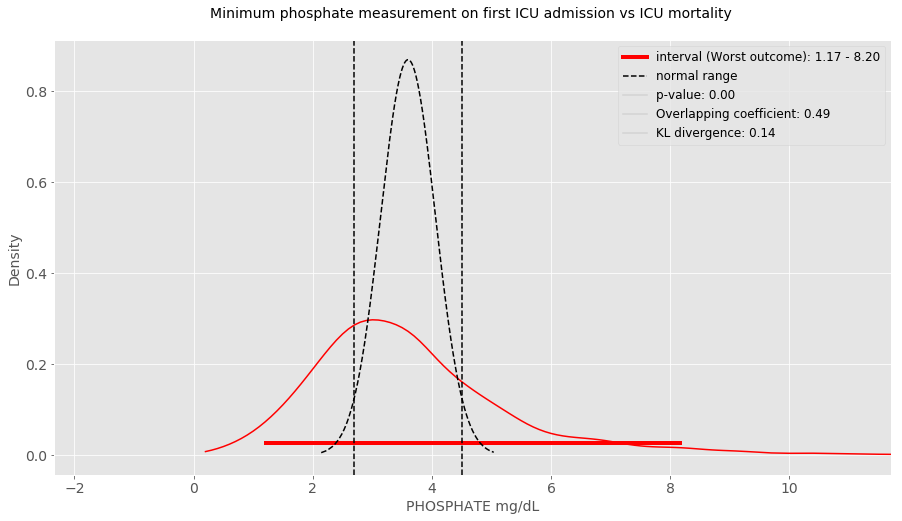

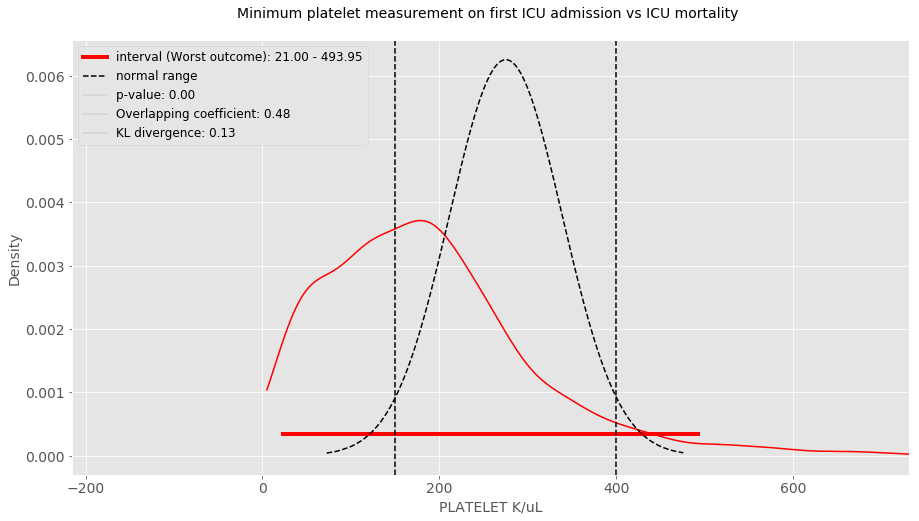

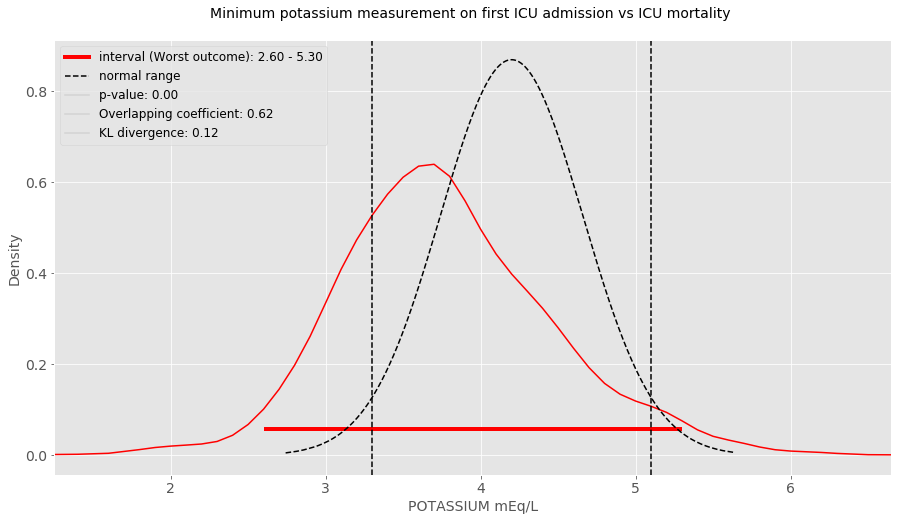

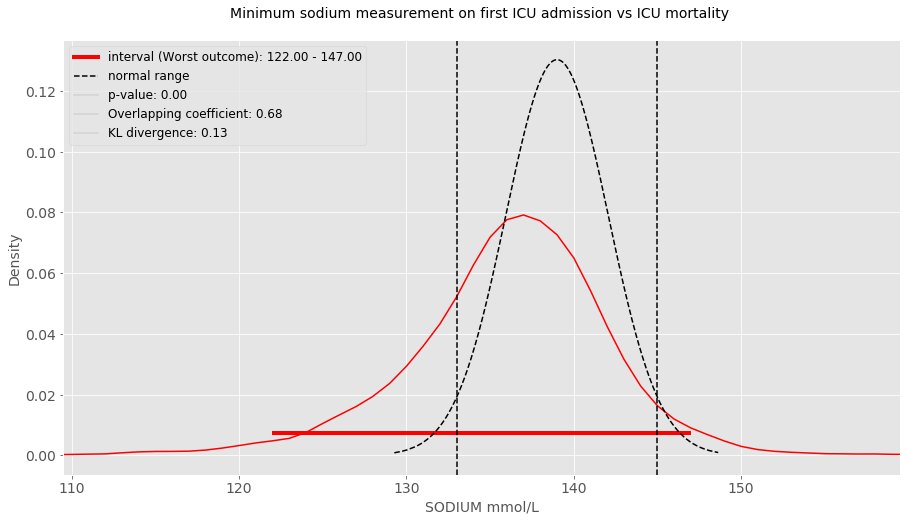

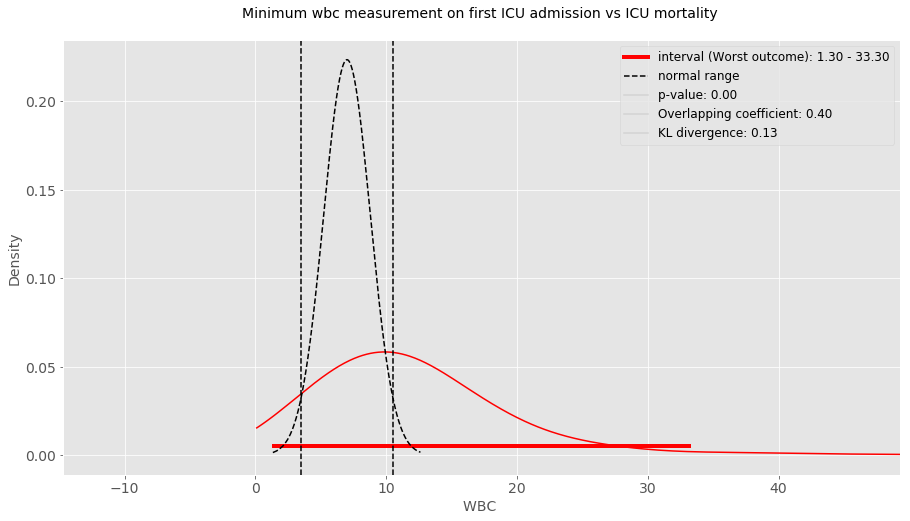

In [10]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().count()
    
    # get median, variance, mean
    med_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().median()
    var_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().var()
    skew_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().skew()
    #los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    # Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[l][0], lab_ranges[l][1])
    norm_sample = range_dist.rvs(size=n_nonsurv, random_state=20171024)
    test_data = data[l.lower()+'_min'][data.mort_icu==1].dropna()
    
    # Change to non-parametric test to avoid making assumptions
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_min'].dropna())
    t_stat, p_val = mannwhitneyu(norm_sample, test_data)
    
    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    #data[l.lower()+'_min'].dropna().plot.kde(
    #    alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data_kde = gaussian_kde(test_data.as_matrix())
    plt.plot(test_data.sort_values(), data_kde.pdf(test_data.sort_values()), color='r')
    
    # Calculate KL divergence 
    kl = entropy(pk=data_kde.pdf(test_data), qk=norm_sample)    
    
    ovl = OverlapParam(data_kde, range_dist, l)
    # add 95% percentail 
    a1 = test_data.quantile(0.025)
    a2 = test_data.quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    
    # Plot label
    plt.plot([], label='interval (Worst outcome): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='red', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='KL divergence: {}'.format(format(kl, '.2f')), color='lightgrey')
    plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Minimum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

## Maximum value plots

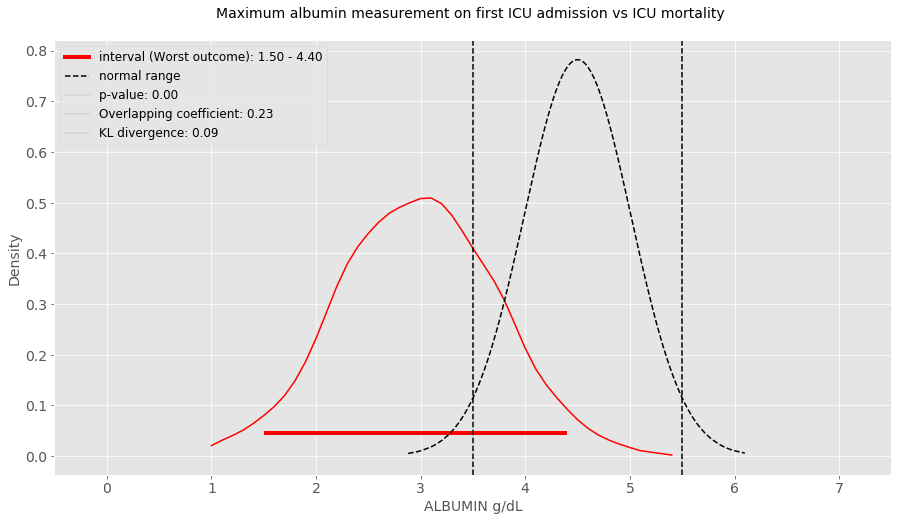

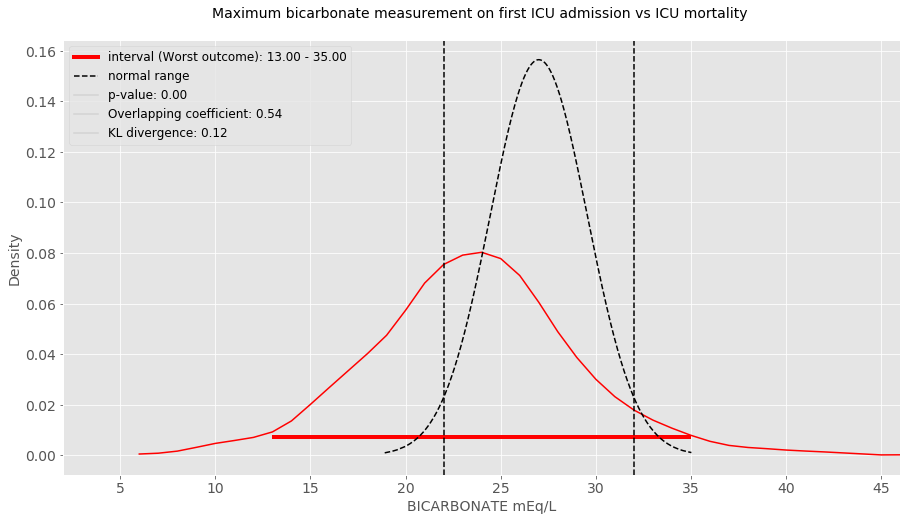

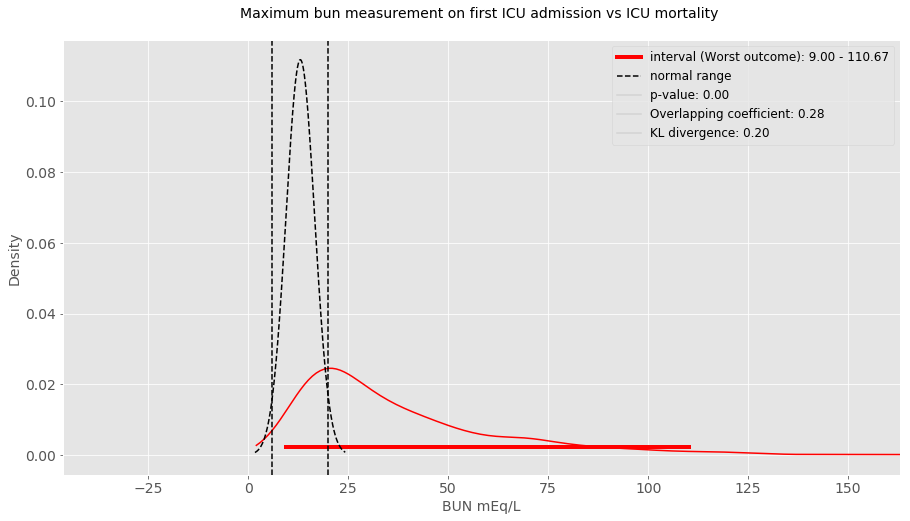

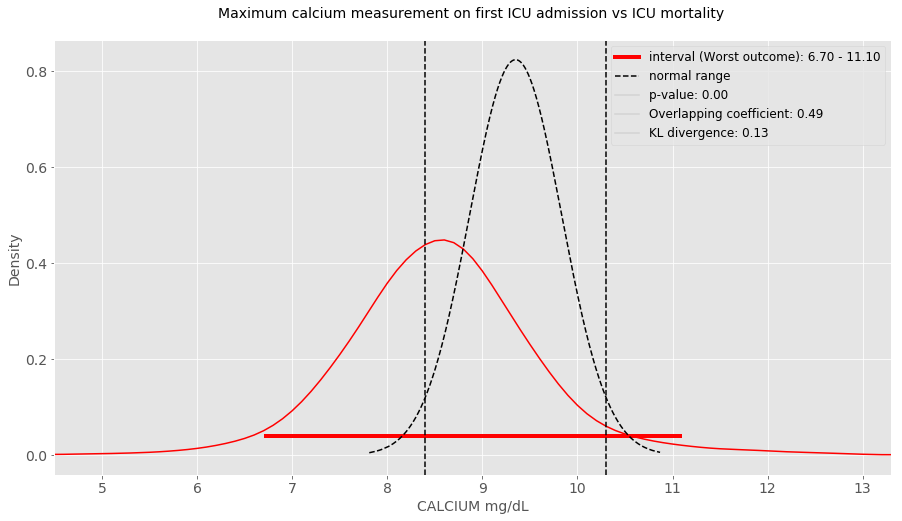

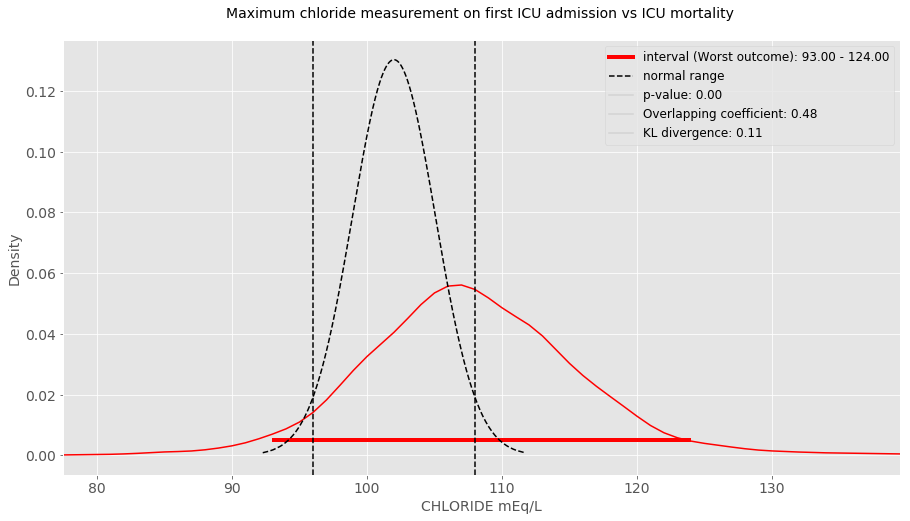

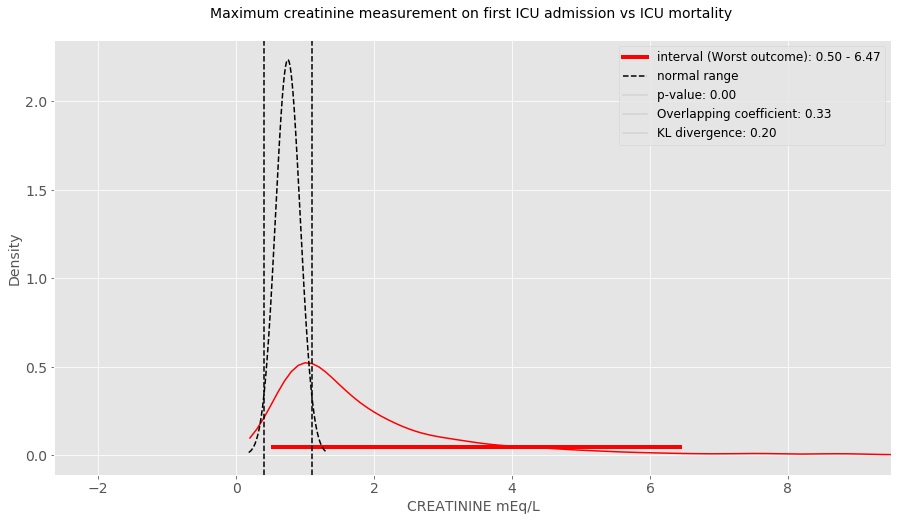

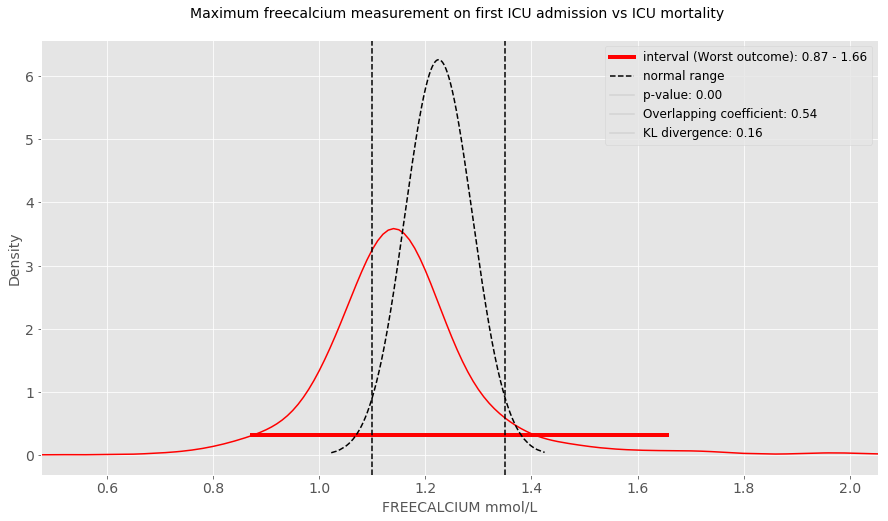

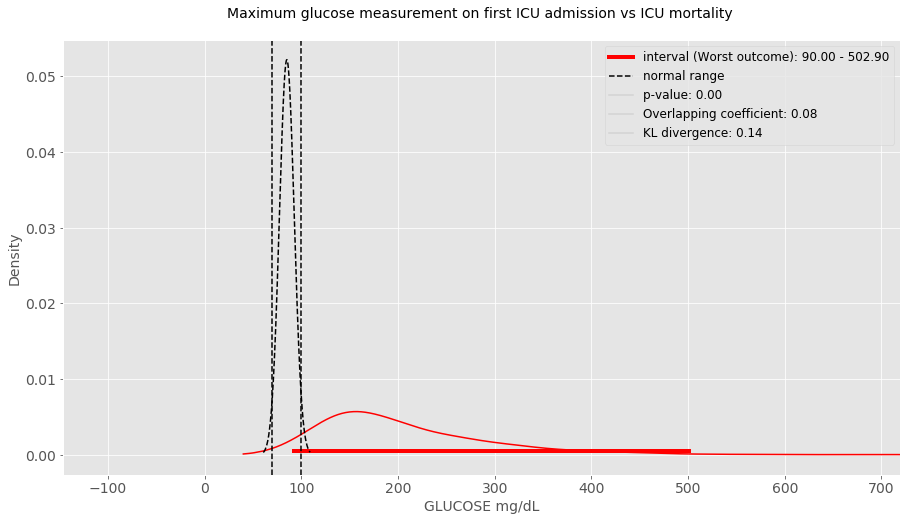

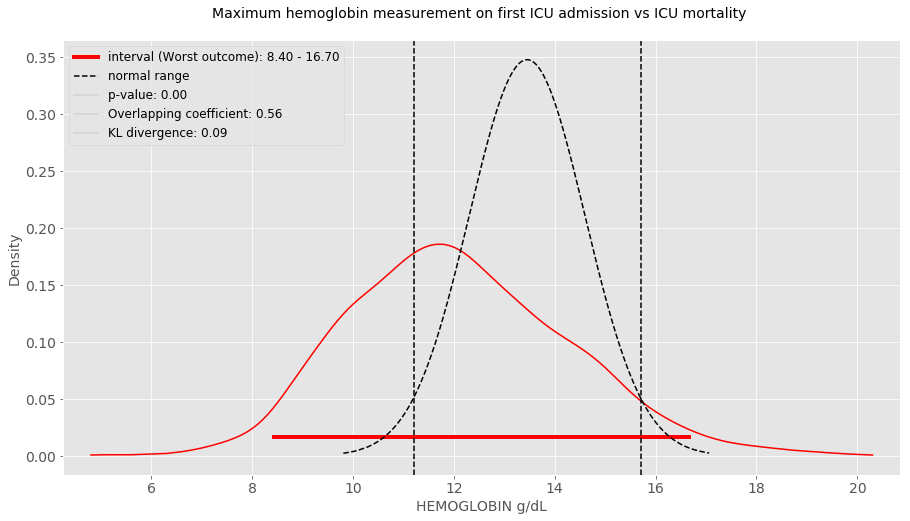

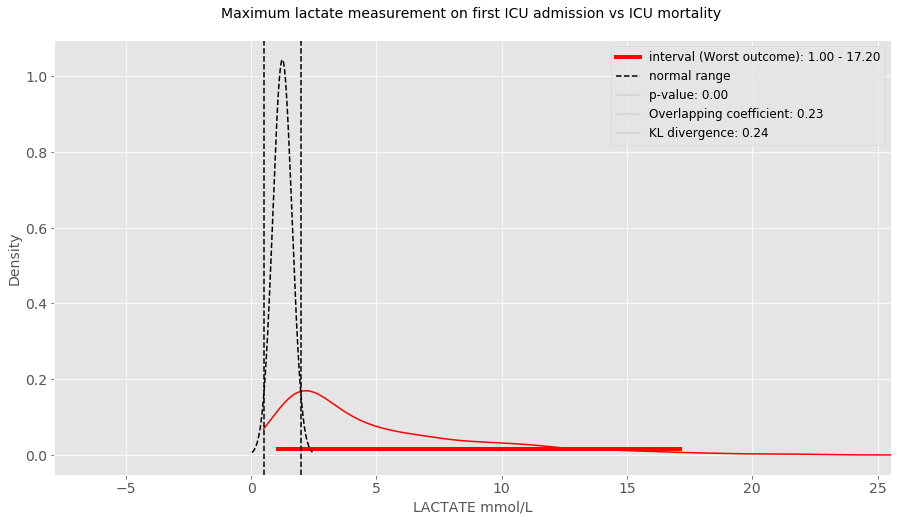

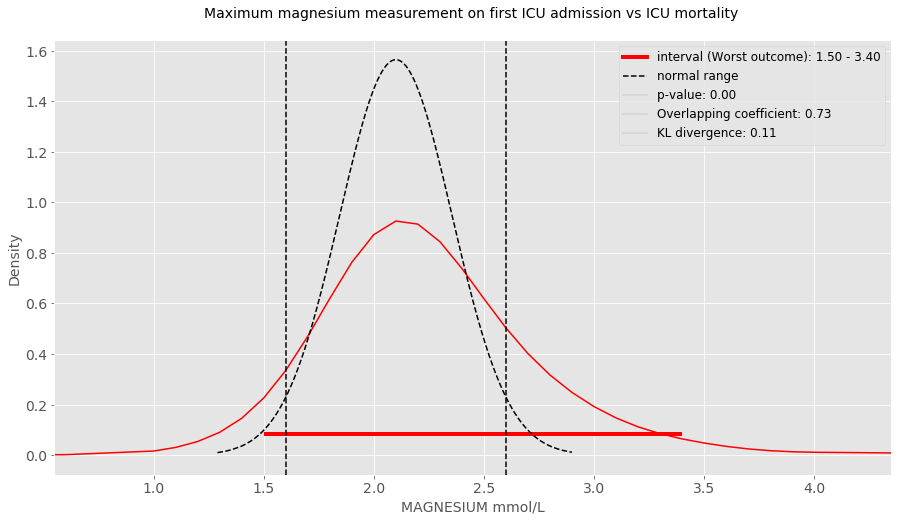

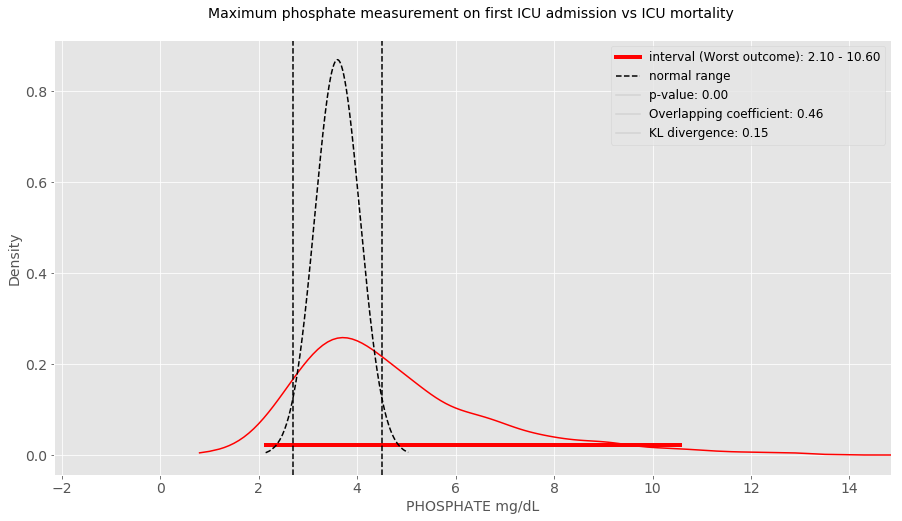

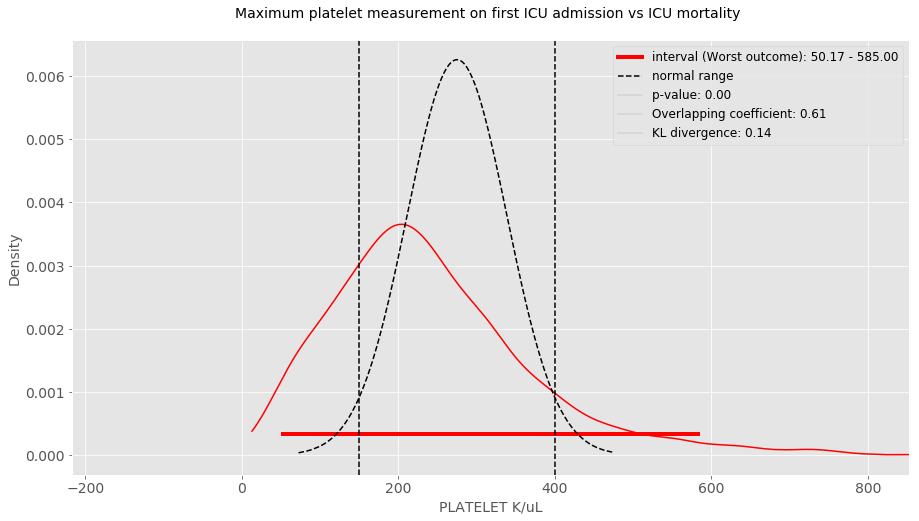

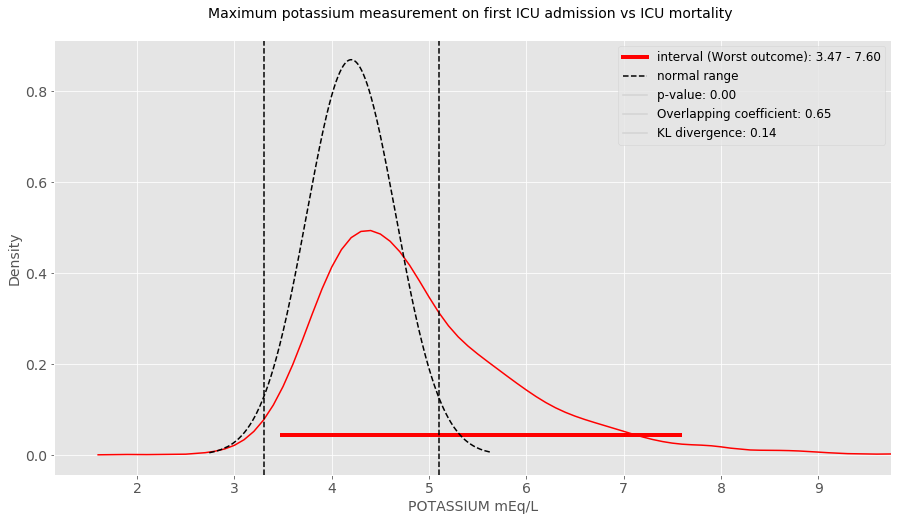

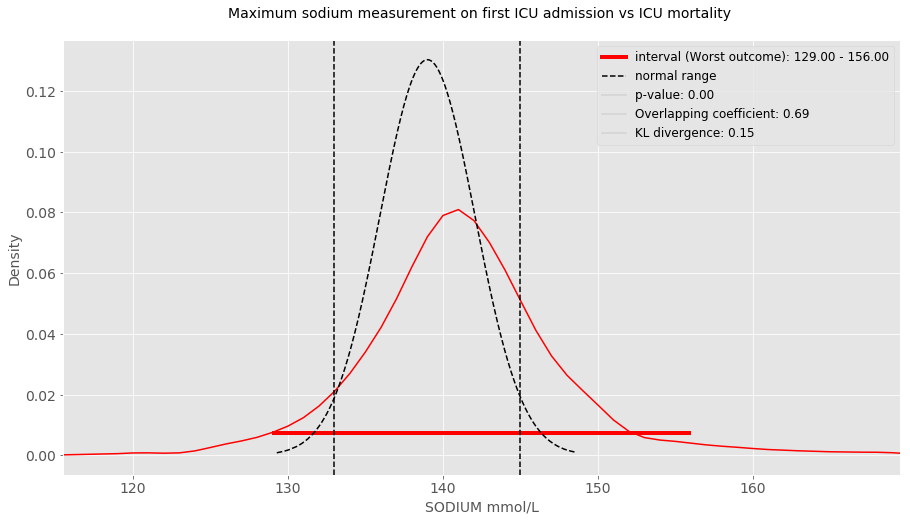

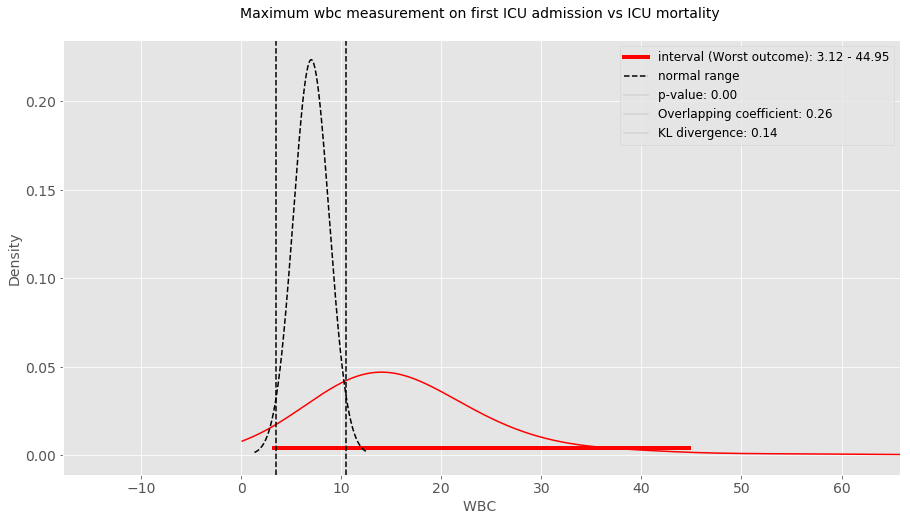

In [24]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().count()
    
    # get median, variance, mean
    med_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().median()
    var_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().var()
    skew_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().skew()
    los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    # Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[l][0], lab_ranges[l][1])
    norm_sample = range_dist.rvs(size=n_nonsurv, random_state=20171024)
    test_data = data[l.lower()+'_max'][data.mort_icu==1].dropna()
    
    # Change to non-parametric test to avoid making assumptions
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_min'].dropna())
    t_stat, p_val = mannwhitneyu(norm_sample, test_data)
    
    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    #data[l.lower()+'_min'].dropna().plot.kde(
    #    alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data_kde = gaussian_kde(test_data.as_matrix())
    plt.plot(test_data.sort_values(), data_kde.pdf(test_data.sort_values()), color='r')
    
    # Calculate KL divergence 
    kl = entropy(pk=data_kde.pdf(test_data), qk=norm_sample)    
    
    ovl = OverlapParam(data_kde, range_dist, l)
    # add 95% percentail 
    a1 = test_data.quantile(0.025)
    a2 = test_data.quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    
    # Plot label
    plt.plot([], label='interval (Worst outcome): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='r', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='KL divergence: {}'.format(format(kl, '.2f')), color='lightgrey')
    plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Maximum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

# Best outcome group vs worst outcome group
## Minimal value plots

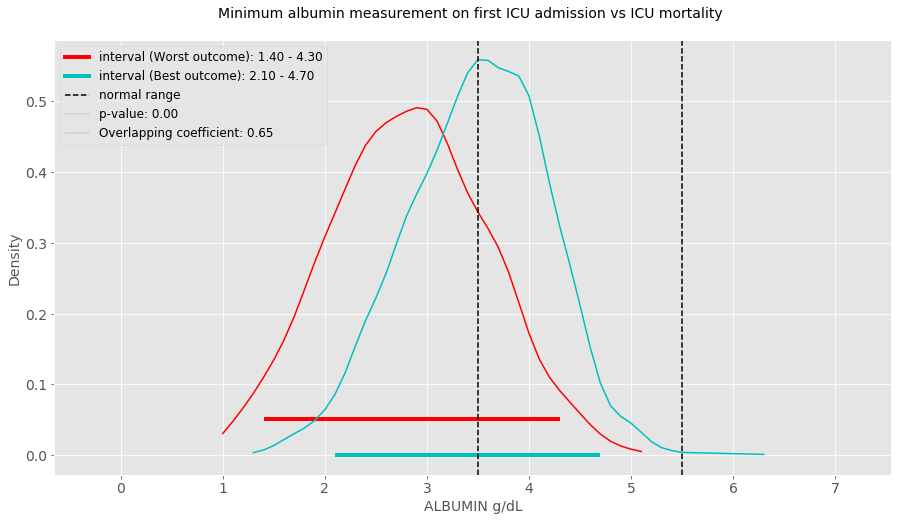

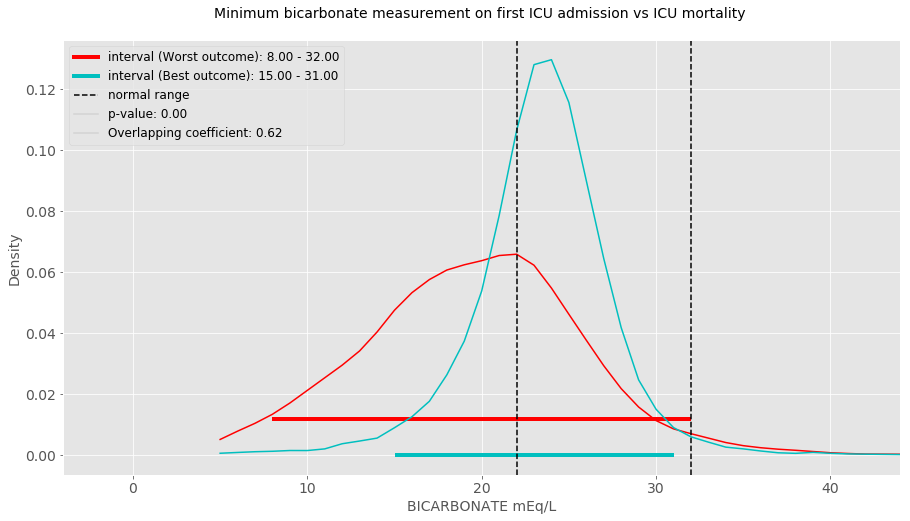

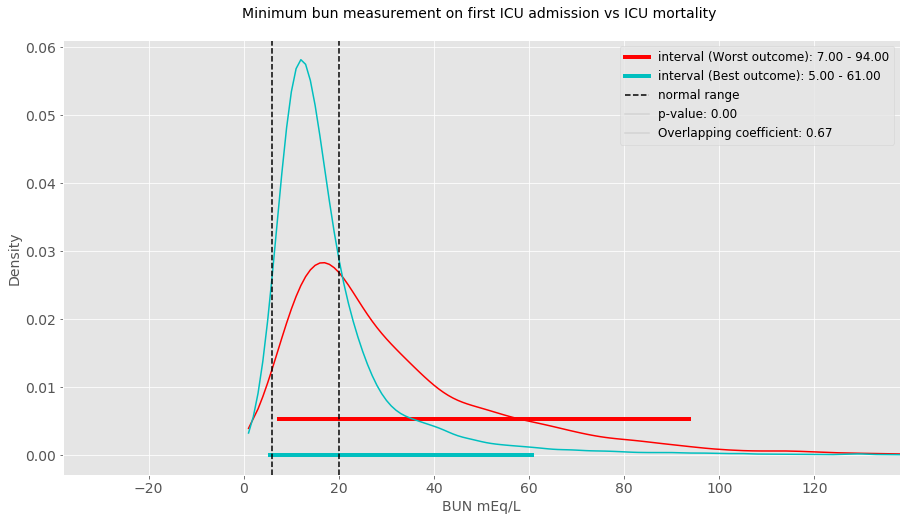

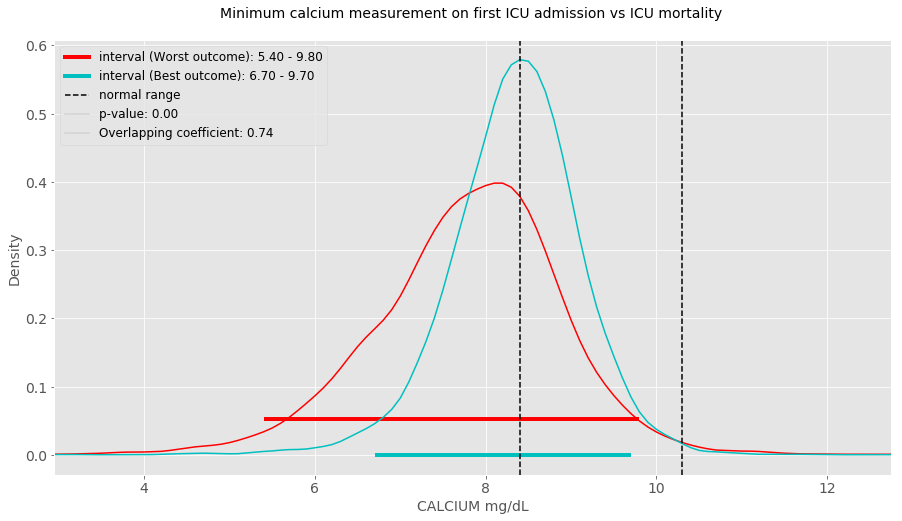

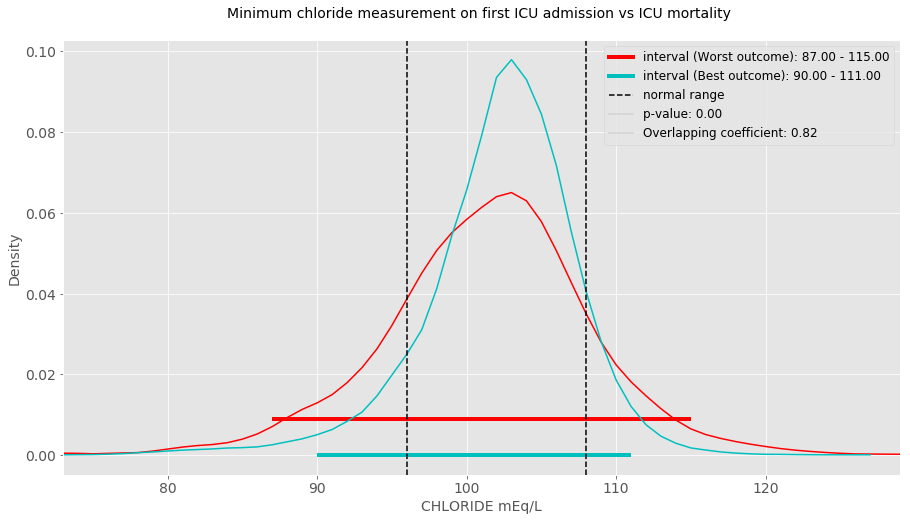

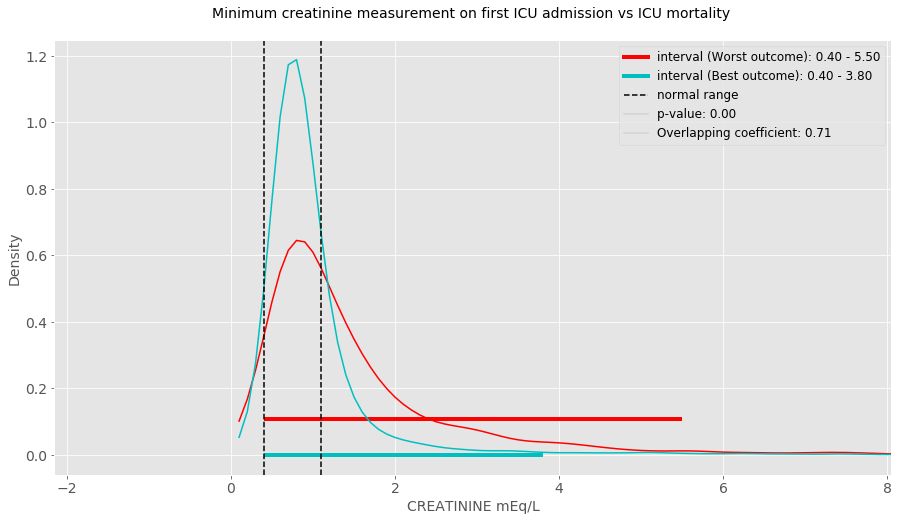

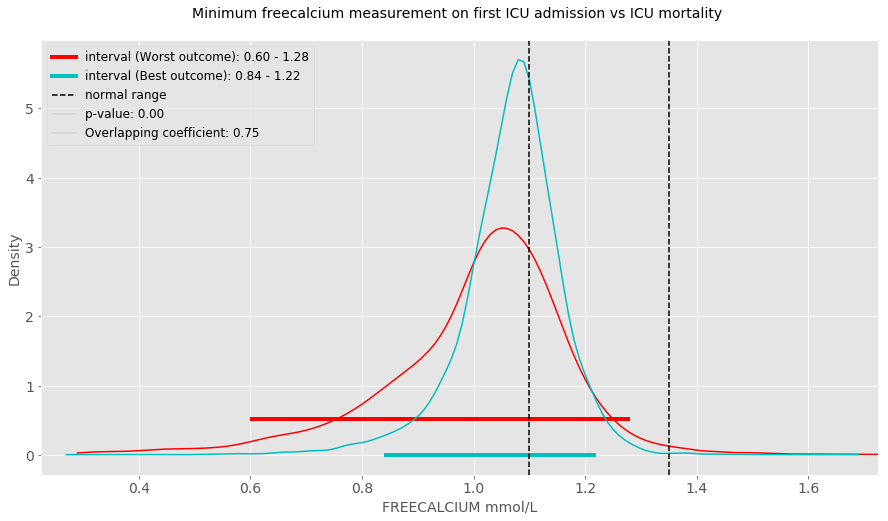

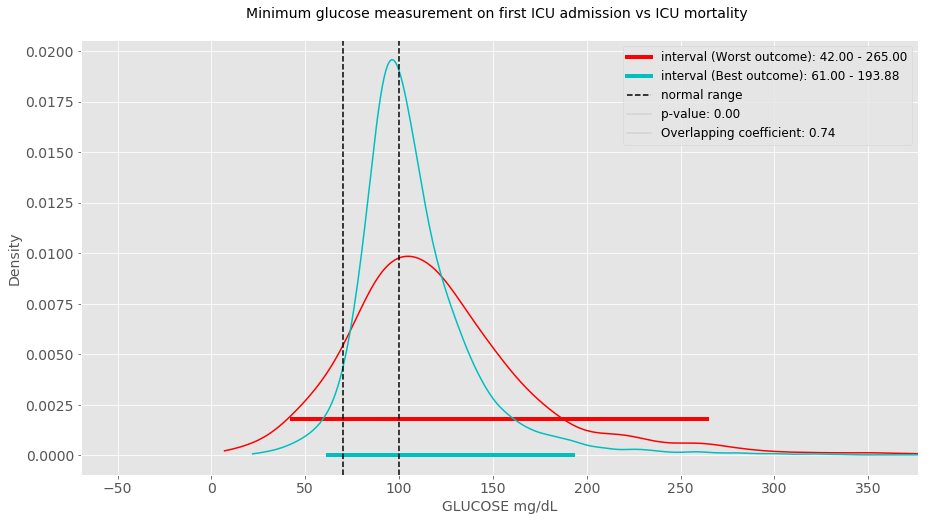

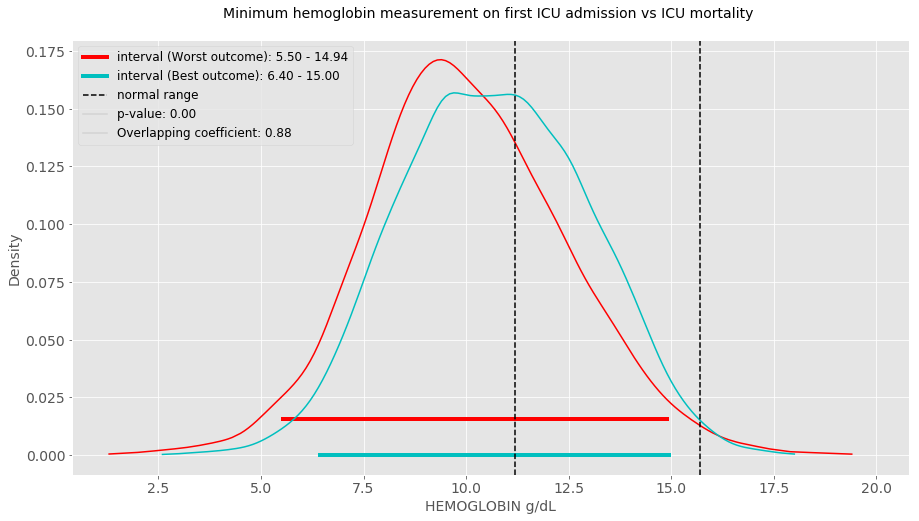

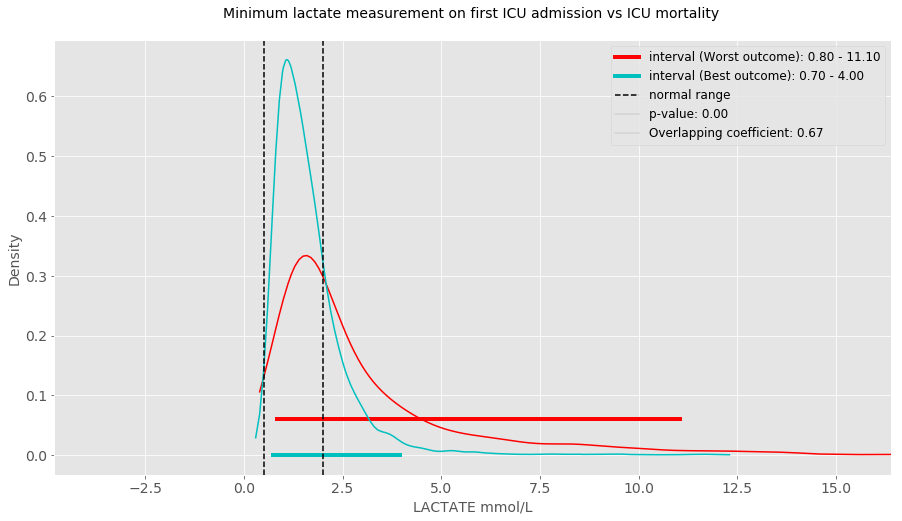

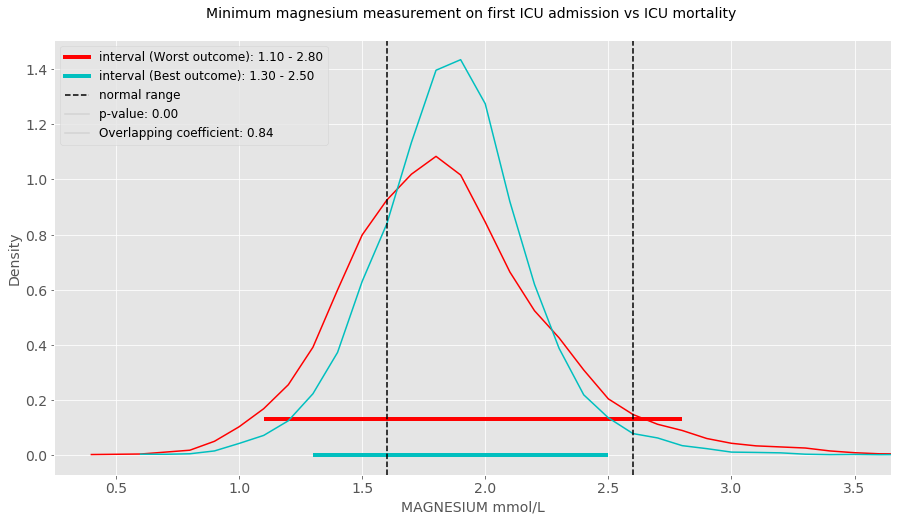

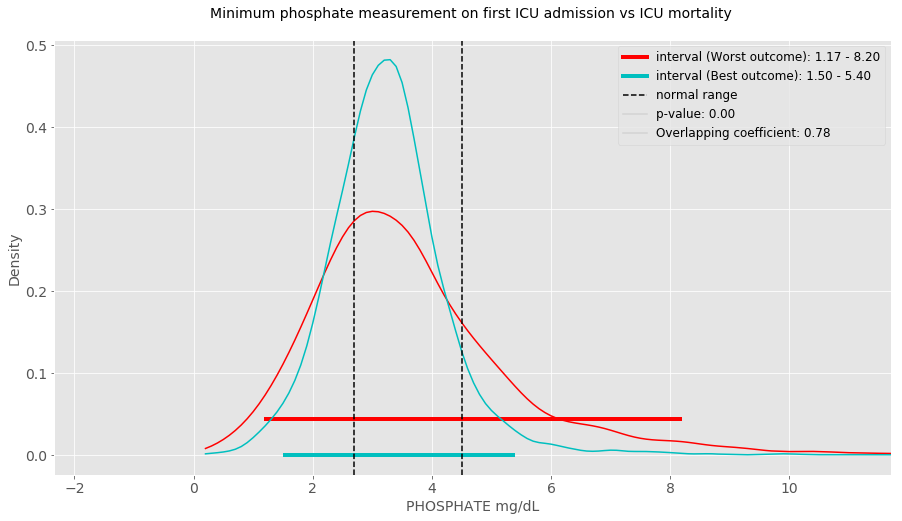

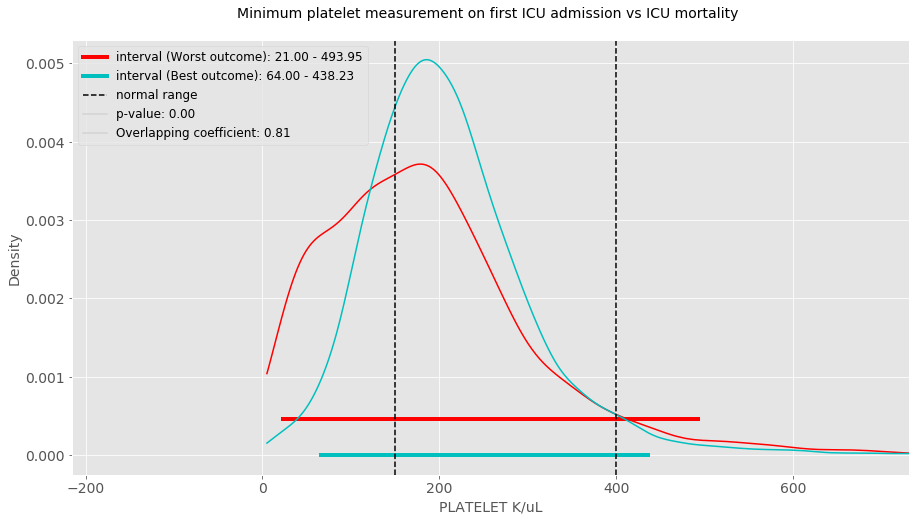

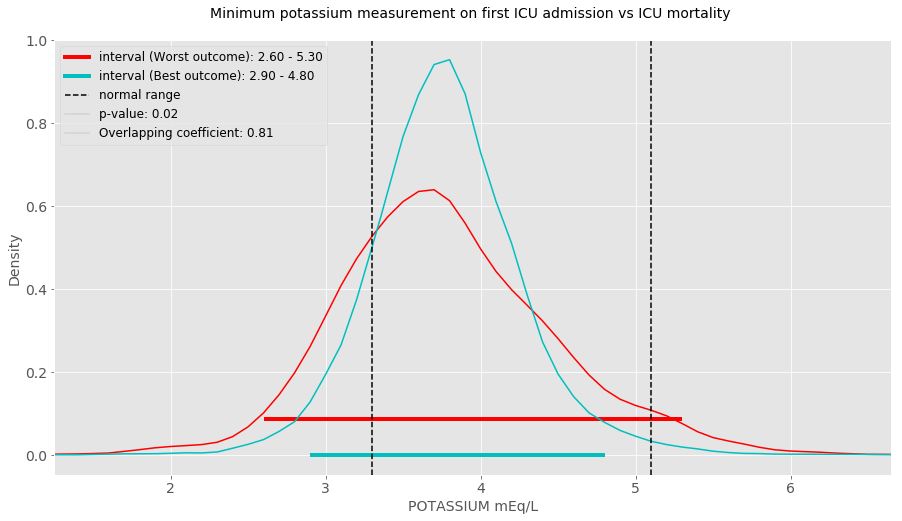

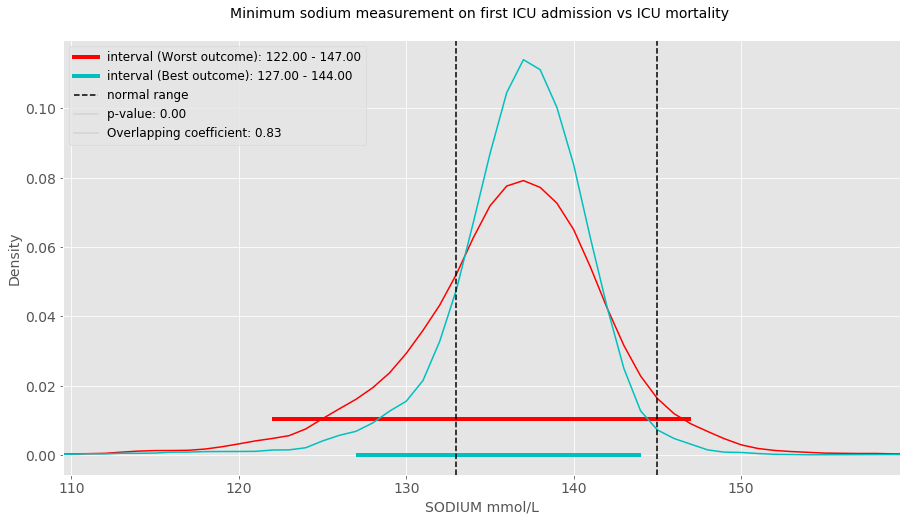

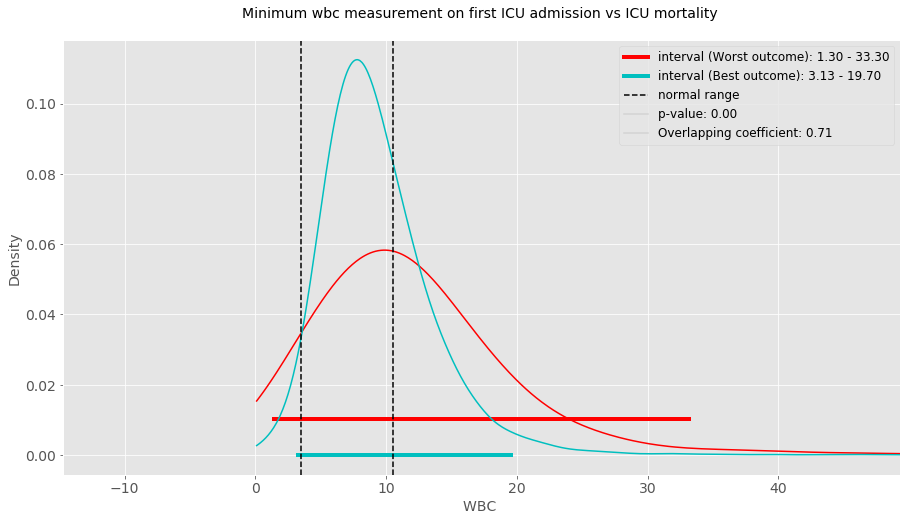

In [19]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().count()
    n_less = data[l.lower()+'_min'][cond_less].dropna().count()
    quater = n_less / 4 
    
    # get median, variance, mean
    med_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().median()
    med_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).median()
    var_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().var()
    var_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).var()
    skew_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().skew()
    skew_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).skew() 
    los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    test_data1 = data[l.lower()+'_min'][data.mort_icu==1].dropna()
    test_data2 = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater)
    
    # Change to non-parametric test to avoid making assumptions
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_min'].dropna())
    t_stat, p_val = mannwhitneyu(test_data1, test_data2)
    
    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    #data[l.lower()+'_min'].dropna().plot.kde(
    #    alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data1_kde = gaussian_kde(test_data1.as_matrix())
    plt.plot(test_data1.sort_values(), data1_kde.pdf(test_data1.sort_values()), color='r')
    data2_kde = gaussian_kde(test_data2.as_matrix())
    plt.plot(test_data2.sort_values(), data2_kde.pdf(test_data2.sort_values()), color='c')
    
    #data2_sample = data2_kde.rvs(n_less / 4)
    # Calculate KL divergence 
    #kl = entropy(pk=data1_kde.pdf(test_data1), qk=data2_kde.pdf(test_data2))    
    
    ovl = OverlapParam(data1_kde, data2_kde, l)
    # add 95% percentail 
    a1 = test_data1.quantile(0.025)
    a2 = test_data1.quantile(0.975)
    b1 = test_data2.quantile(0.025)
    b2 = test_data2.quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    plt.hlines(y=0, xmin = b1, xmax = b2, linewidth=4, linestyle='-', color='c')
    # Plot label
    plt.plot([], label='interval (Worst outcome): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='red', linewidth=4)
    plt.plot([], label='interval (Best outcome): {} - {}'.format(format(b1, '.2f'), format(b2, '.2f')),
                 color='c', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    #plt.plot([], label='KL divergence: {}'.format(format(kl, '.2f')), color='lightgrey')
    #plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Minimum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

# Maximum

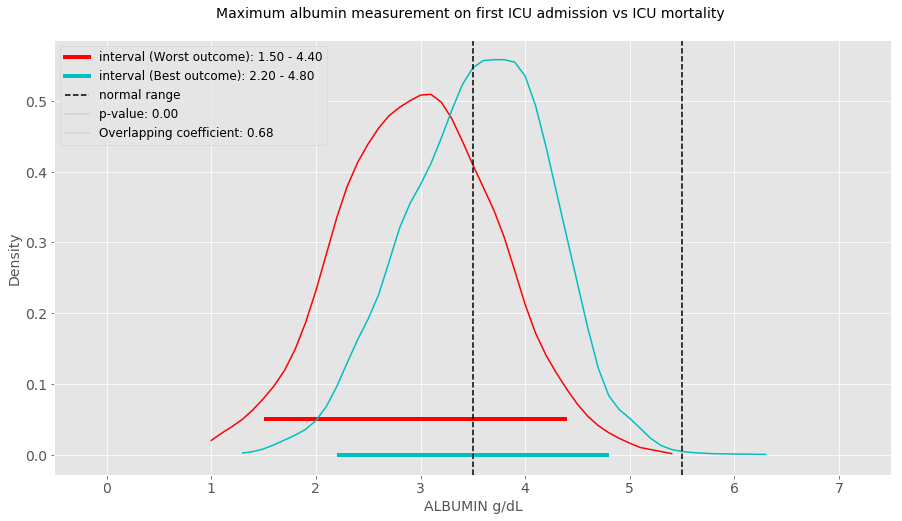

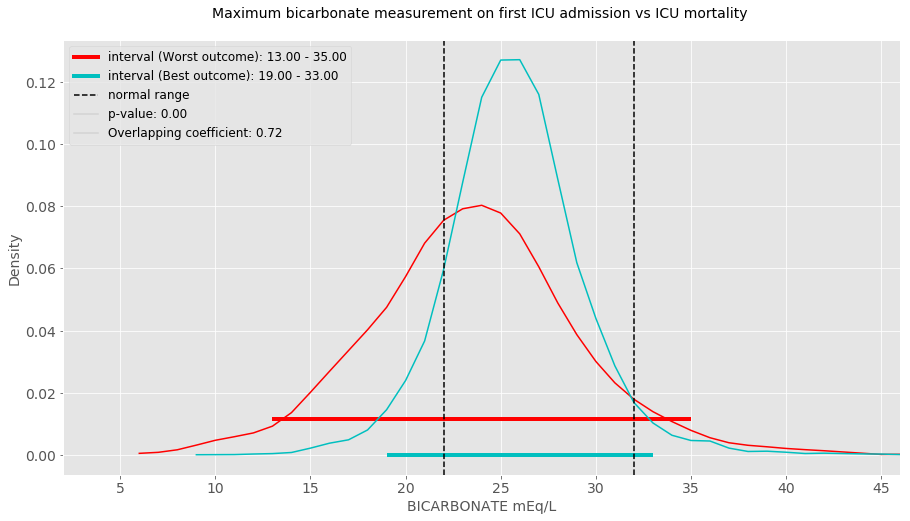

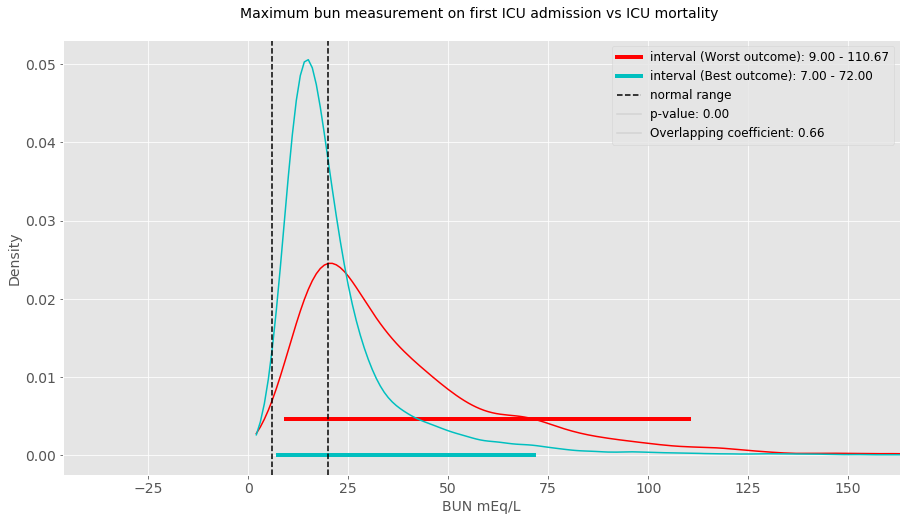

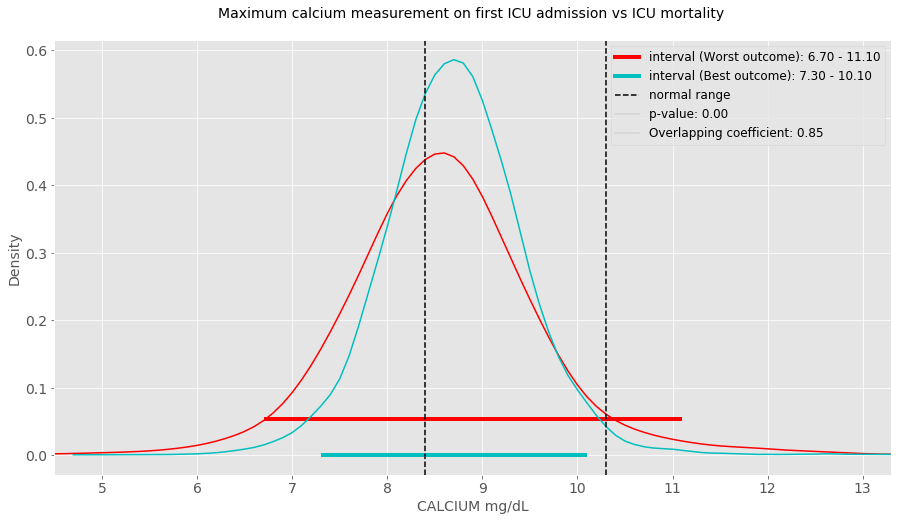

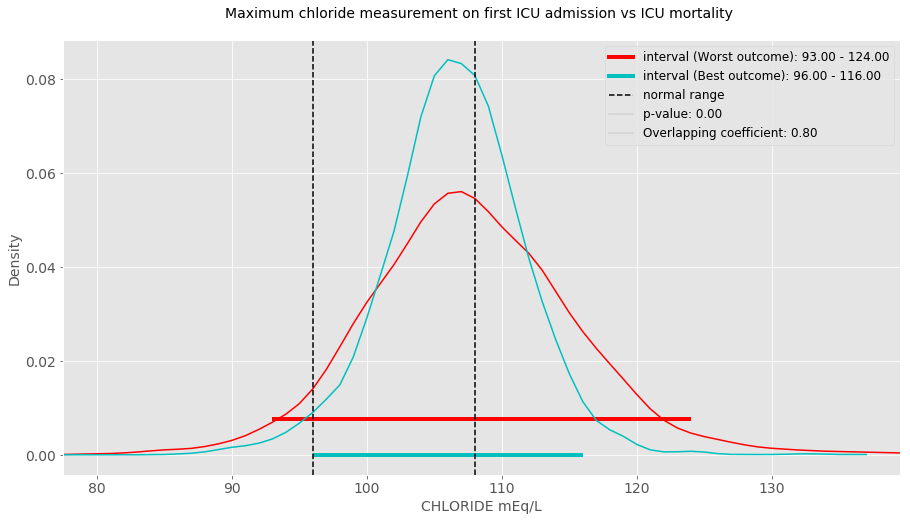

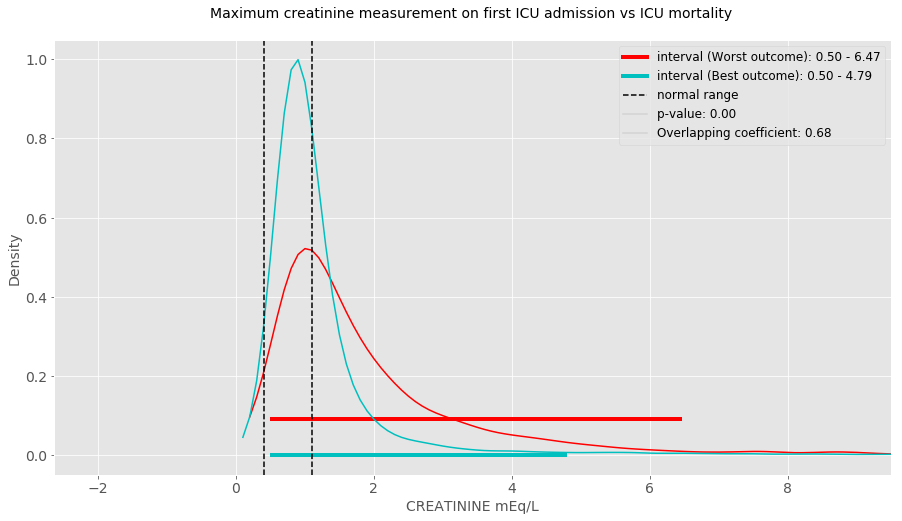

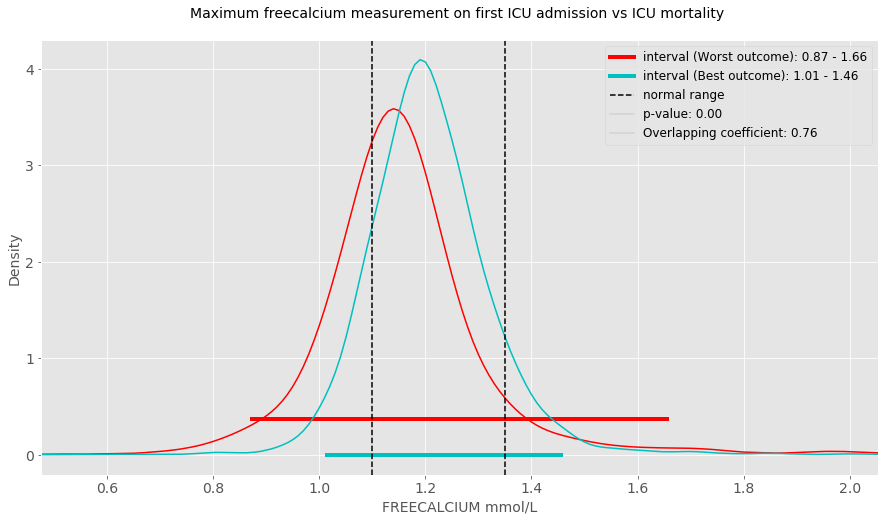

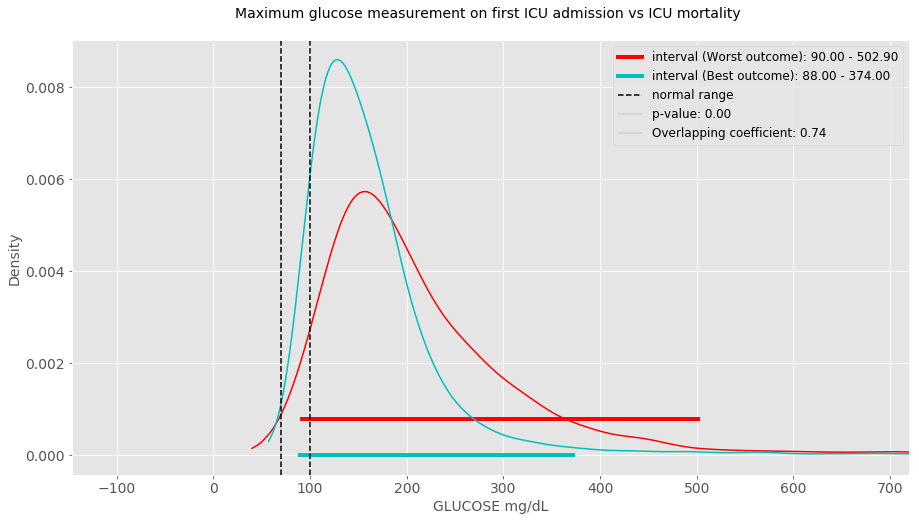

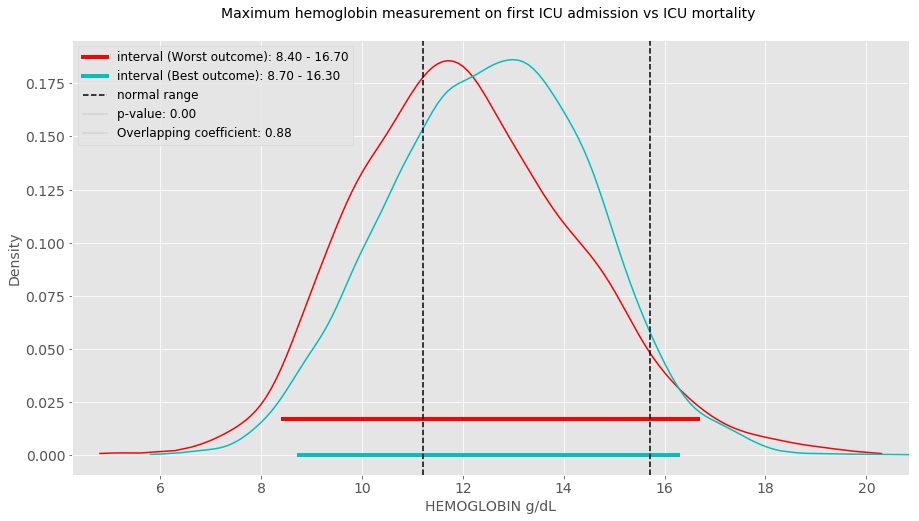

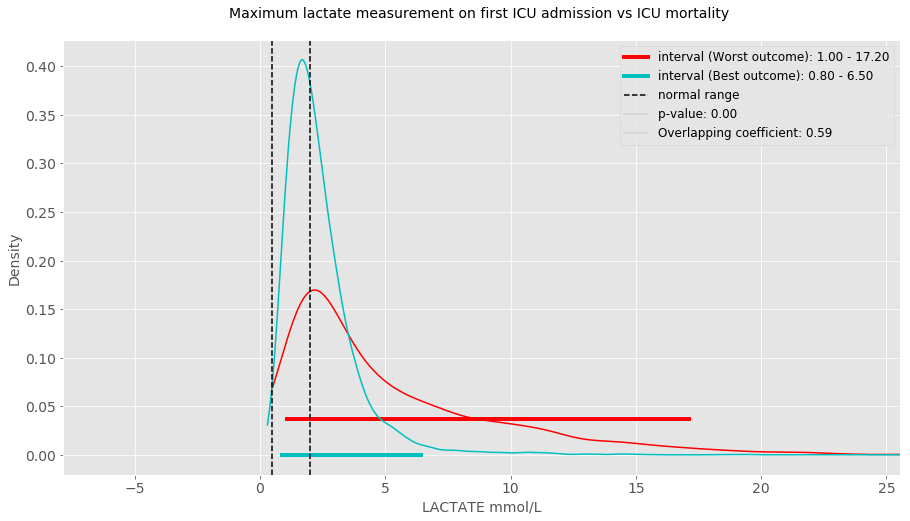

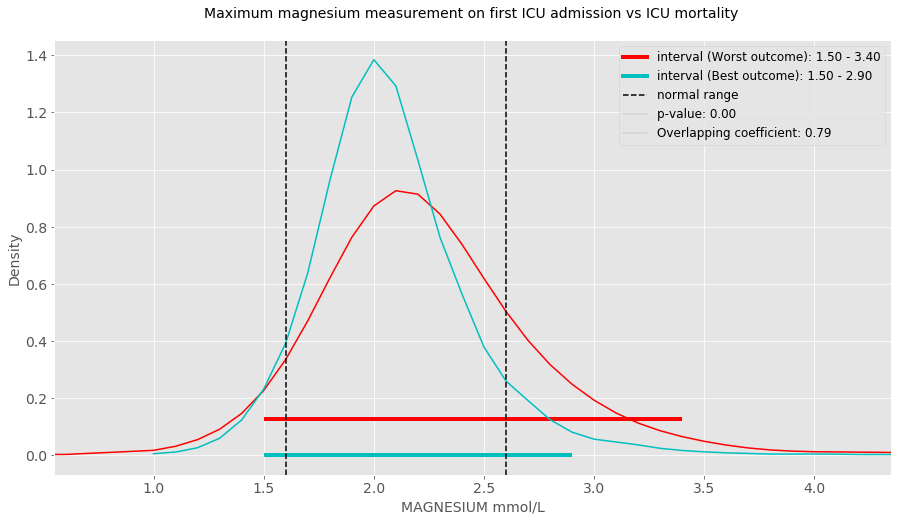

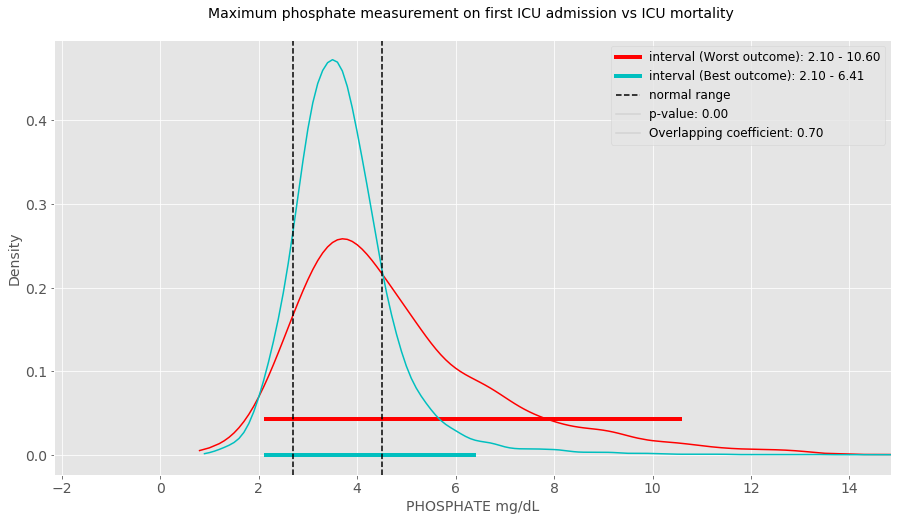

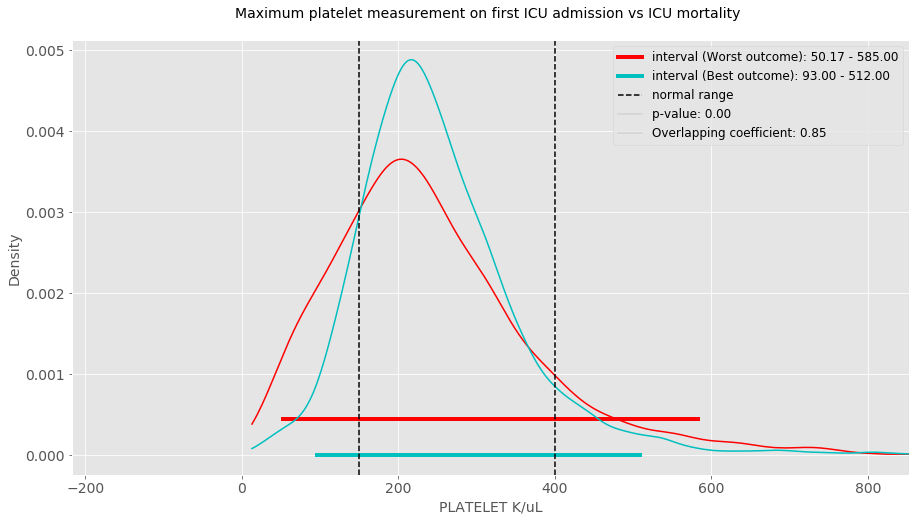

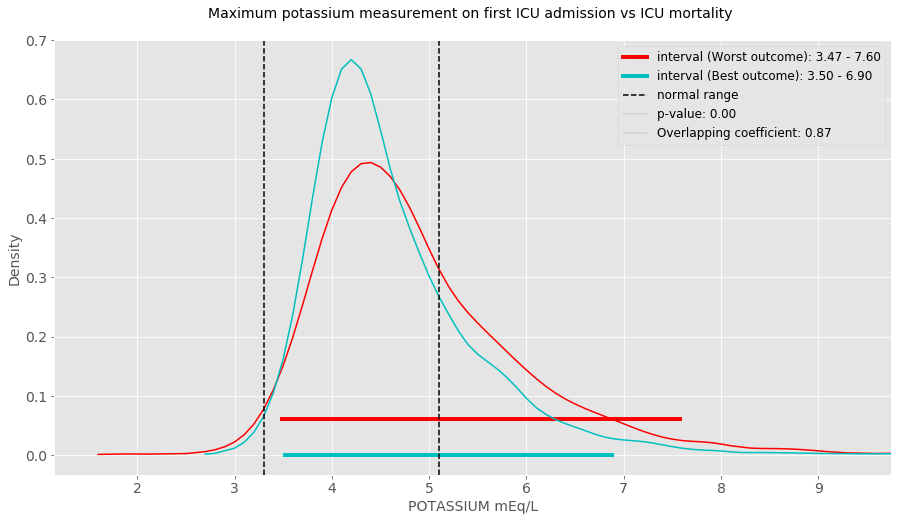

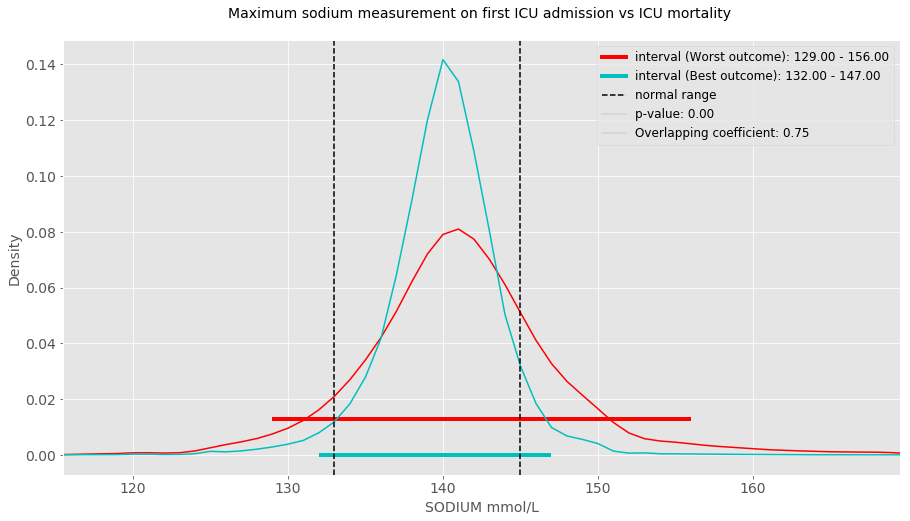

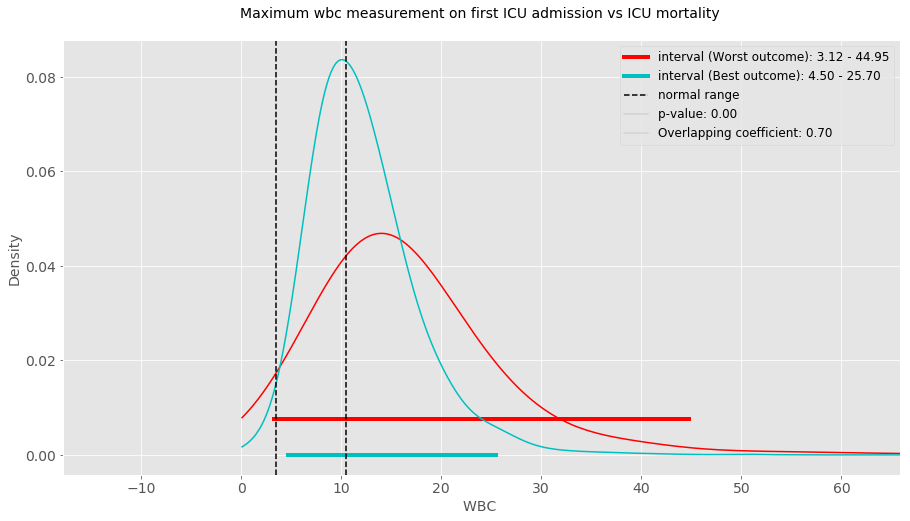

In [20]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().count()
    n_less = data[l.lower()+'_max'][cond_less].dropna().count()
    quater = n_less / 4 
    
    # get median, variance, mean
    med_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().median()
    med_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).median()
    var_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().var()
    var_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).var()
    skew_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().skew()
    skew_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).skew() 
    los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    test_data1 = data[l.lower()+'_max'][data.mort_icu==1].dropna()
    test_data2 = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater)
    
    # Change to non-parametric test to avoid making assumptions
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_min'].dropna())
    t_stat, p_val = mannwhitneyu(test_data1, test_data2)
    
    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    #data[l.lower()+'_min'].dropna().plot.kde(
    #    alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data1_kde = gaussian_kde(test_data1.as_matrix())
    plt.plot(test_data1.sort_values(), data1_kde.pdf(test_data1.sort_values()), color='r')
    data2_kde = gaussian_kde(test_data2.as_matrix())
    plt.plot(test_data2.sort_values(), data2_kde.pdf(test_data2.sort_values()), color='c')
    
    #data2_sample = data2_kde.rvs(n_less / 4)
    # Calculate KL divergence 
    #kl = entropy(pk=data1_kde.pdf(test_data1), qk=data2_kde.pdf(test_data2))    
    
    ovl = OverlapParam(data1_kde, data2_kde, l)
    # add 95% percentail 
    a1 = test_data1.quantile(0.025)
    a2 = test_data1.quantile(0.975)
    b1 = test_data2.quantile(0.025)
    b2 = test_data2.quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    plt.hlines(y=0, xmin = b1, xmax = b2, linewidth=4, linestyle='-', color='c')
    # Plot label
    plt.plot([], label='interval (Worst outcome): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='red', linewidth=4)
    plt.plot([], label='interval (Best outcome): {} - {}'.format(format(b1, '.2f'), format(b2, '.2f')),
                 color='c', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    #plt.plot([], label='KL divergence: {}'.format(format(kl, '.2f')), color='lightgrey')
    #plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Maximum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)